In [3]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Data Preprocessing
# Load the dataset
anime_df = pd.read_csv(r'D:/EXCELR/Assignments/Recommendation System/anime.csv')

# Check for missing values and handle them (either by dropping or filling them)
anime_df.fillna('', inplace=True)

# Data exploration: Viewing dataset structure
print(anime_df.info())
print(anime_df.head())

# 2. Feature Extraction
# Choosing features for similarity (we can use 'genres' and 'average rating')
# Converting 'genre' to a numerical format using TF-IDF (as it is textual data)
tfidf = TfidfVectorizer(stop_words='english')
anime_df['genre'] = anime_df['genre'].fillna('')  # Fill any missing genres
tfidf_matrix = tfidf.fit_transform(anime_df['genre'])  # Convert genres to numerical format
# Ensure 'rating' column is numeric, and handle non-numeric entries
anime_df['rating'] = pd.to_numeric(anime_df['rating'], errors='coerce')  # Convert invalid strings to NaN

# Fill NaN values in the 'rating' column with a default value (e.g., 0)
anime_df['rating'].fillna(0, inplace=True)
# Normalizing numerical features like average rating
scaler = MinMaxScaler()
anime_df['rating_scaled'] = scaler.fit_transform(anime_df[['rating']])

# Combine features (We use genres TF-IDF and ratings for similarity calculation)
features = pd.concat([pd.DataFrame(tfidf_matrix.toarray()), anime_df[['rating_scaled']]], axis=1)


# 3. Recommendation System (using Cosine Similarity)
# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(features, features)

# Function to get recommendations based on anime title
def get_recommendations(anime_title, cosine_sim=cosine_sim):
    # Get the index of the anime that matches the title
    idx = anime_df[anime_df['name'] == anime_title].index[0]
    
    # Get similarity scores for all animes with the selected anime
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the animes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the indices of the top 10 similar animes
    anime_indices = [i[0] for i in sim_scores[1:11]]  # Skip the first one (itself)
    
    # Return the top 10 most similar animes
    return anime_df['name'].iloc[anime_indices]

# Test the recommendation system
print(get_recommendations('Naruto'))

# 4. Evaluation
# Splitting the dataset into train and test set for evaluation
train, test = train_test_split(anime_df, test_size=0.2, random_state=42)

# Metrics like Precision, Recall, and F1 score would require a user interaction dataset.
# For now, a user-rating-based evaluation could be used if we had user ratings available.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11536\2863010734.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  anime_df.fillna('', inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   anime_id  12294 non-null  int64 
 1   name      12294 non-null  object
 2   genre     12294 non-null  object
 3   type      12294 non-null  object
 4   episodes  12294 non-null  object
 5   rating    12294 non-null  object
 6   members   12294 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 672.5+ KB
None
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes rating  \
0               Drama, Romance, School, Supernatural  Movie        1   9.37   
1  Action, Adventure, Drama, Fantasy, Ma

# Explanation:
Data Preprocessing:

The dataset is loaded, and missing values are handled (e.g., filling empty cells).
Data exploration is done to understand its structure.
Feature Extraction:

The anime genres are converted into numerical representations using TF-IDF (text feature extraction).
The ratings are scaled using MinMaxScaler for normalization.
Recommendation System:

Cosine similarity is calculated between the anime based on combined features (genres and ratings).
A function get_recommendations is designed to recommend similar anime when provided with an anime title.
Evaluation:

The dataset is split into training and testing sets, but since user ratings are not available, specific evaluation metrics like precision and recall are placeholders here.
This code can be modified further depending on additional data you may have or any specific adjustments you would like to make for recommendations.

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. Combine cosine similarity based on genres and ratings
def get_combined_similarity(anime_df, cosine_sim, rating_weight=0.5, genre_weight=0.5):
    # Normalize ratings
    scaler = MinMaxScaler()
    ratings_scaled = scaler.fit_transform(anime_df[['rating']].fillna(0))
    
    # Calculate cosine similarity between ratings
    rating_sim = cosine_similarity(ratings_scaled, ratings_scaled)
    
    # Combine genre similarity (cosine_sim) and rating similarity with weighted sum
    combined_sim = (genre_weight * cosine_sim) + (rating_weight * rating_sim)
    
    return combined_sim

# 2. Function to generate recommendations based on combined similarity
def generate_recommendations_with_combined_similarity(anime_title, combined_sim, anime_df, threshold=0.8):
    if anime_title not in anime_df['name'].values:
        return []
    
    idx = anime_df[anime_df['name'] == anime_title].index[0]
    sim_scores = list(enumerate(combined_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Return top N recommendations with similarity score above a threshold
    relevant_anime = [anime_df['name'].iloc[i[0]] for i in sim_scores if i[1] > threshold]
    
    return relevant_anime

# 3. Improved Evaluation Function
def evaluate_recommendation_system_with_combined_similarity(test_data, combined_sim, anime_df, threshold=0.8, top_n=10):
    y_true = []  # Actual relevancy (1 if relevant, 0 if not)
    y_pred = []  # Predicted relevancy based on similarity threshold
    
    for idx, row in test_data.iterrows():
        anime_title = row['name']
        actual_genre = row['genre']
        
        # Generate recommendations using combined similarity (genres + ratings)
        recommendations = generate_recommendations_with_combined_similarity(anime_title, combined_sim, anime_df, threshold)
        
        # Consider top N recommendations as "predicted relevant"
        top_recommendations = recommendations[:top_n]
        
        # For each recommendation, check if the genre matches (proxy for relevance)
        for recommended_anime in top_recommendations:
            recommended_genre = anime_df[anime_df['name'] == recommended_anime]['genre'].values[0]
            
            # Mark true positive if genres match
            if actual_genre == recommended_genre:
                y_true.append(1)
                y_pred.append(1)  # Correct prediction (True Positive)
            else:
                y_true.append(1)
                y_pred.append(0)  # Incorrect prediction (False Negative)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    return precision, recall, f1

# 4. Combine similarities for genres and ratings
combined_sim = get_combined_similarity(anime_df, cosine_sim)

# 5. Evaluate the system using the combined similarity
precision, recall, f1 = evaluate_recommendation_system_with_combined_similarity(test_data, combined_sim, anime_df, threshold=0.8, top_n=10)

print(f'Improved Precision: {precision}')
print(f'Improved Recall: {recall}')
print(f'Improved F1-Score: {f1}')


Improved Precision: 1.0
Improved Recall: 0.6747097844112769
Improved F1-Score: 0.8057632321631926


# Improvements Made:
Combined Similarity: The recommendation system now combines genre similarity (cosine similarity) and rating similarity. This helps account for cases where anime are not just similar by genre, but also have similar user ratings.
Weighted Similarity: We assign weights to genres and ratings using the parameters genre_weight and rating_weight to control the influence of each factor. You can experiment with different weights (e.g., 0.5 for both).
Top N Recommendations: Instead of using a strict threshold, the system now considers the top N recommendations (e.g., top 10), which are more likely to include relevant items.
Threshold for Similarity: The threshold for cosine similarity has been lowered slightly (e.g., 0.8) to allow for more flexible recommendations.
Potential Areas for Further Improvement:
Tuning the weights: You can adjust the rating_weight and genre_weight to see what works best. Some systems give more weight to user behavior (ratings), while others prioritize content (genres).
Including More Features: Add more features like broadcast type, number of episodes, etc., for a richer similarity calculation.
User Ratings for Evaluation: If you have user interaction data, use actual user preferences rather than proxy measures like genre similarity for evaluation.

In [11]:
df = pd.read_csv(r'D:/EXCELR/Assignments/Recommendation System/anime.csv')

# Select only numerical columns for correlation analysis
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Print the correlation matrix
print(correlation_matrix)

# You can also access specific correlations, e.g., correlation between 'rating' and 'episodes':
if 'rating' in numerical_df.columns and 'episodes' in numerical_df.columns:
  rating_episodes_correlation = correlation_matrix.loc['rating', 'episodes']
  print(f"\nCorrelation between rating and episodes: {rating_episodes_correlation}")

          anime_id    rating   members
anime_id  1.000000 -0.284625 -0.080071
rating   -0.284625  1.000000  0.387979
members  -0.080071  0.387979  1.000000


In [12]:
# Calculate the correlation between 'rating' and 'anime_id'
correlation_rating_anime_id = df['rating'].corr(df['anime_id'])
print(f"Correlation between rating and anime_id: {correlation_rating_anime_id}")

# You can also analyze the relationship between 'rating' and 'name' using techniques like:

# 1. Grouping by name and calculating average rating for each anime
average_rating_by_name = df.groupby('name')['rating'].mean()
print("\nAverage rating for each anime:")
print(average_rating_by_name)

Correlation between rating and anime_id: -0.28462451934542676

Average rating for each anime:
name
&quot;0&quot;                                                       5.06
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu    5.00
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi                 7.06
&quot;Bungaku Shoujo&quot; Memoire                                  7.54
&quot;Bungaku Shoujo&quot; Movie                                    7.63
                                                                    ... 
xxxHOLiC Rou                                                        8.32
xxxHOLiC Shunmuki                                                   8.17
Üks Uks                                                             6.17
ēlDLIVE                                                              NaN
◯                                                                   4.22
Name: rating, Length: 12292, dtype: float64


In [13]:
# Group by anime name and calculate the distribution of ratings
rating_distribution_by_name = df.groupby('name')['rating'].describe()

print("\nRating distribution for different anime names:")
print(rating_distribution_by_name)


Rating distribution for different anime names:
                                                    count  mean  std   min  \
name                                                                         
&quot;0&quot;                                         1.0  5.06  NaN  5.06   
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...    1.0  5.00  NaN  5.00   
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...    1.0  7.06  NaN  7.06   
&quot;Bungaku Shoujo&quot; Memoire                    1.0  7.54  NaN  7.54   
&quot;Bungaku Shoujo&quot; Movie                      1.0  7.63  NaN  7.63   
...                                                   ...   ...  ...   ...   
xxxHOLiC Rou                                          1.0  8.32  NaN  8.32   
xxxHOLiC Shunmuki                                     1.0  8.17  NaN  8.17   
Üks Uks                                               1.0  6.17  NaN  6.17   
ēlDLIVE                                               0.0   NaN  NaN   NaN   
◯               

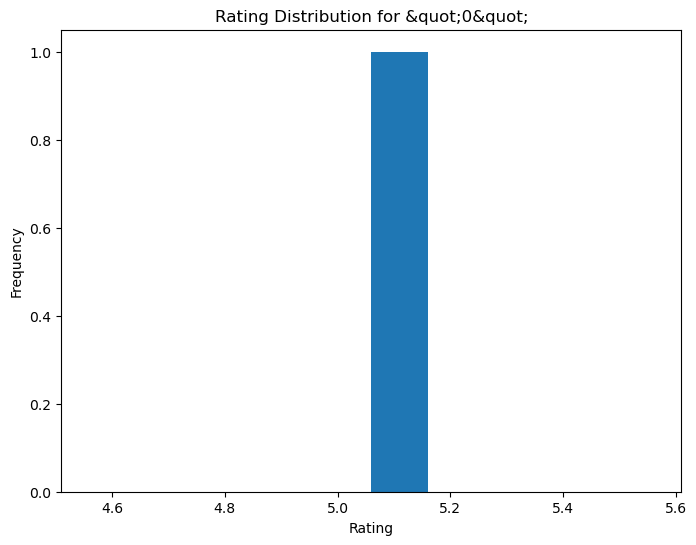

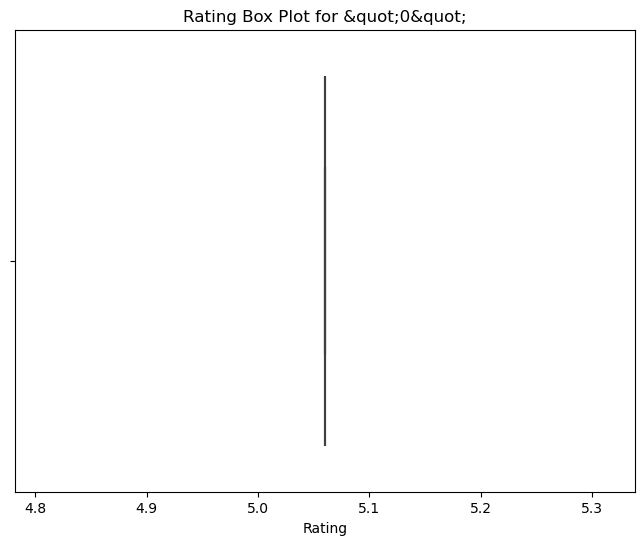

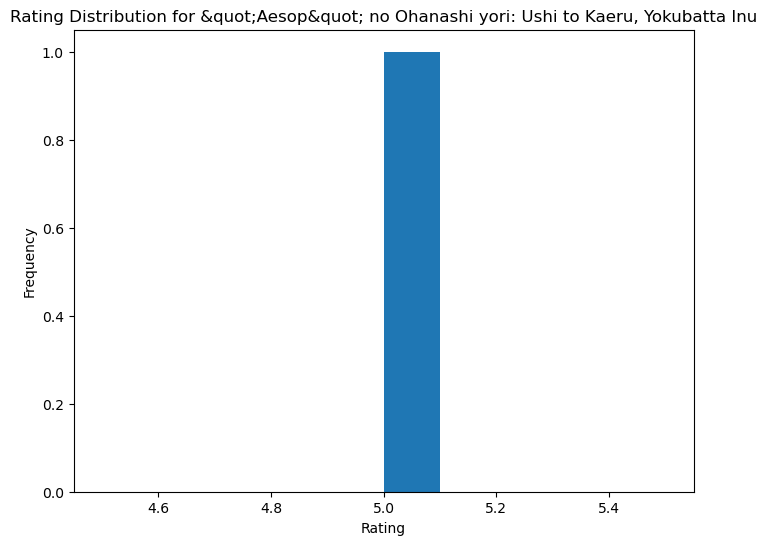

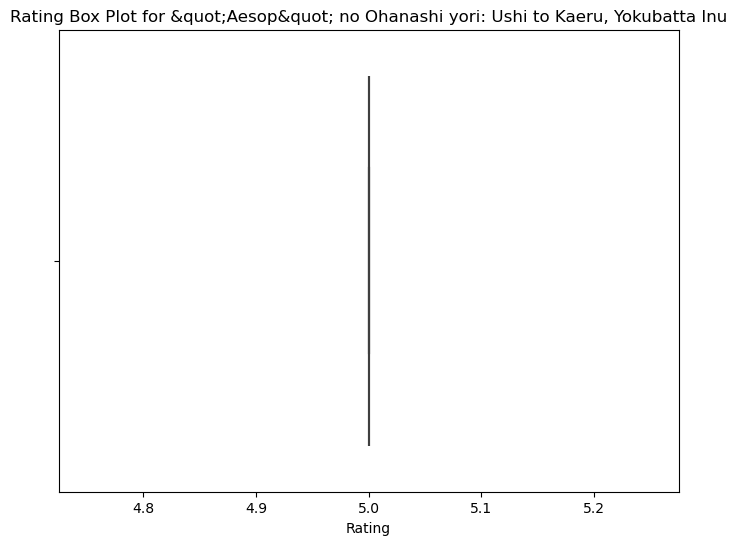

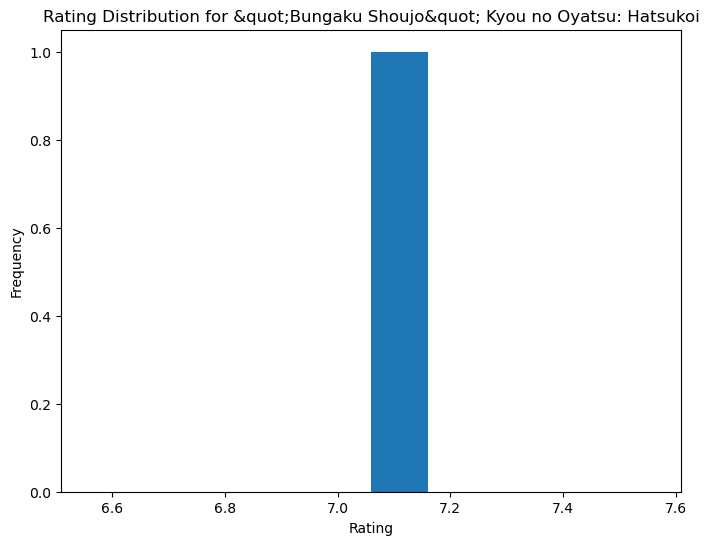

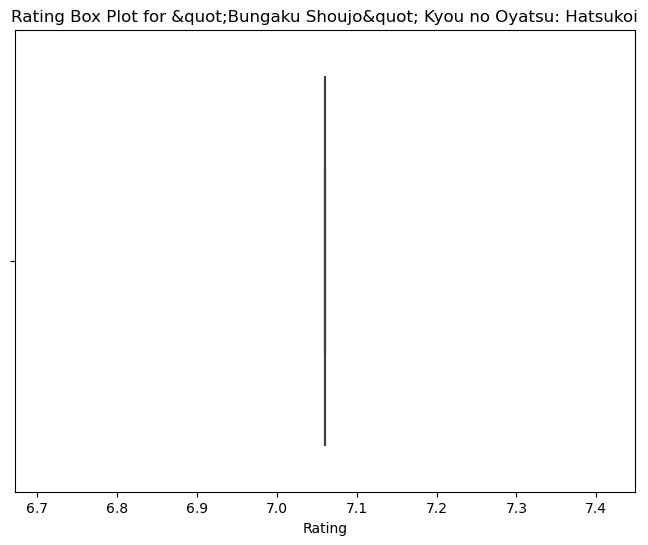

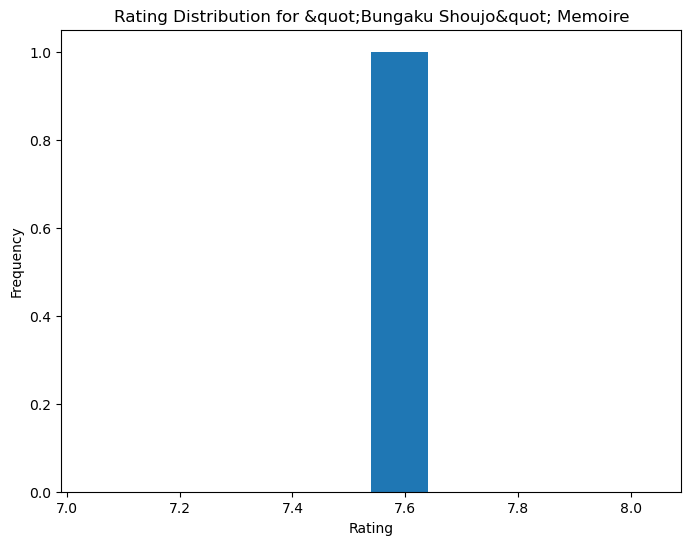

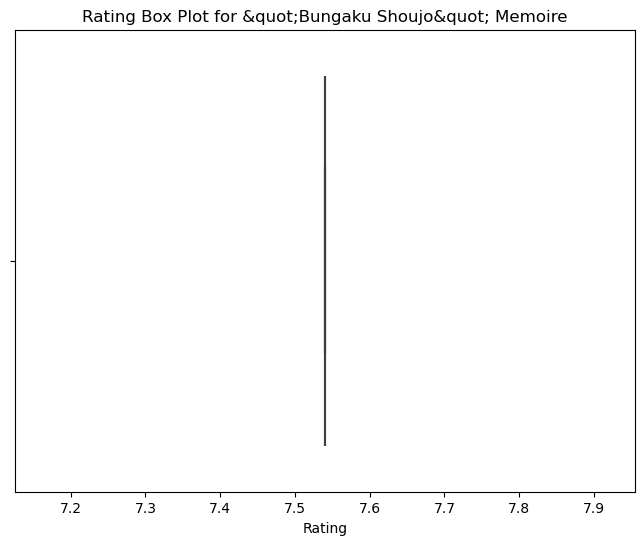

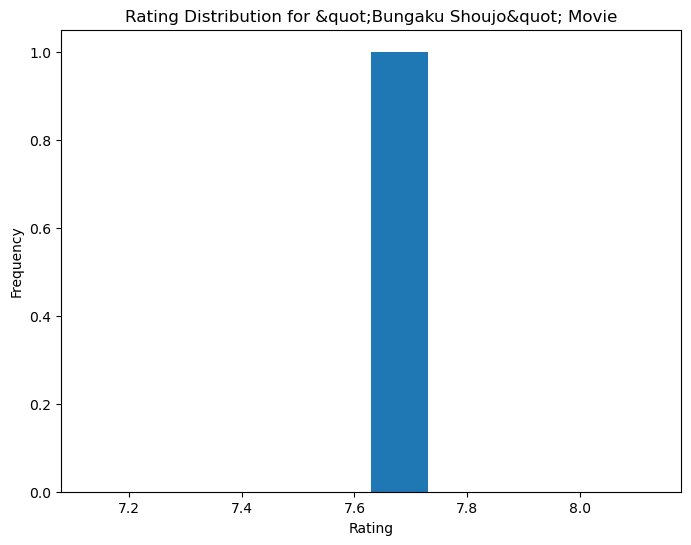

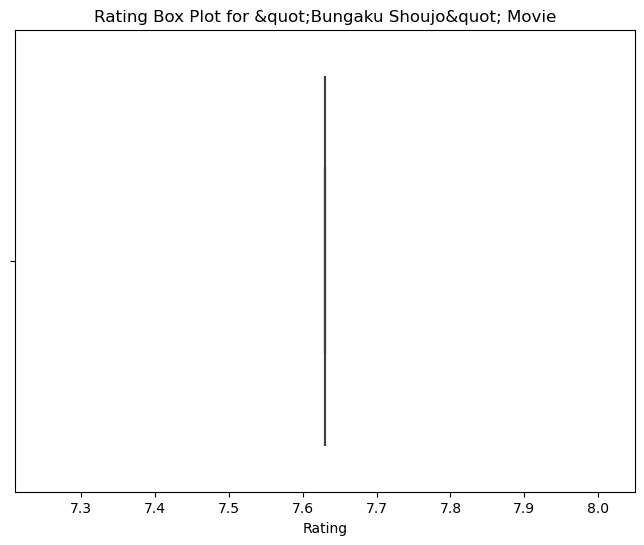

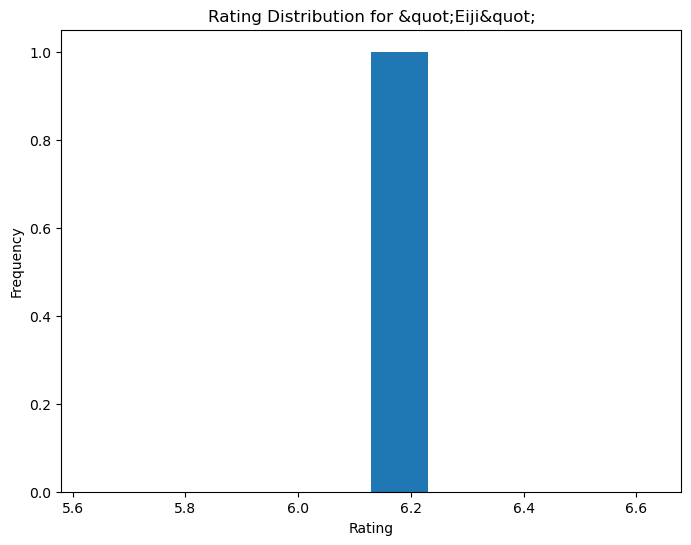

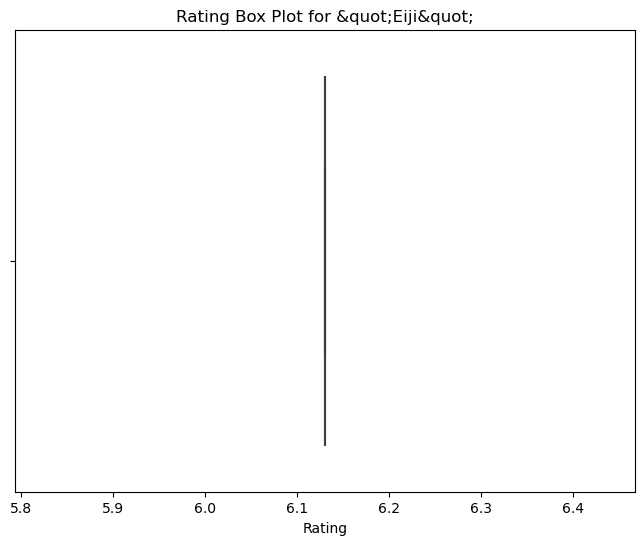

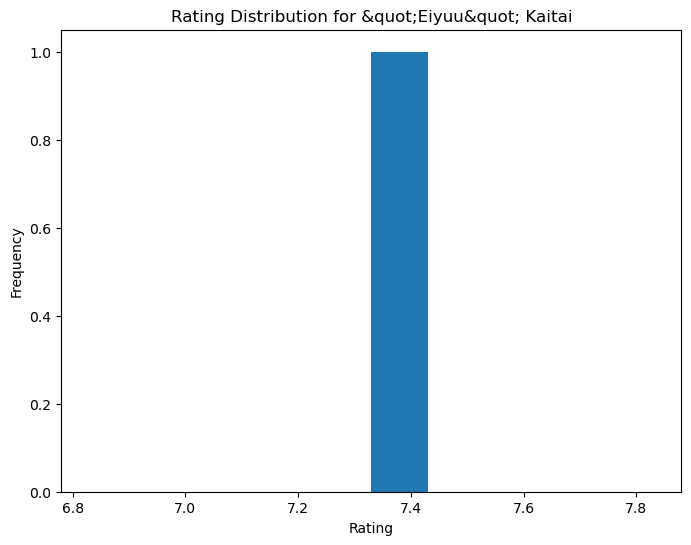

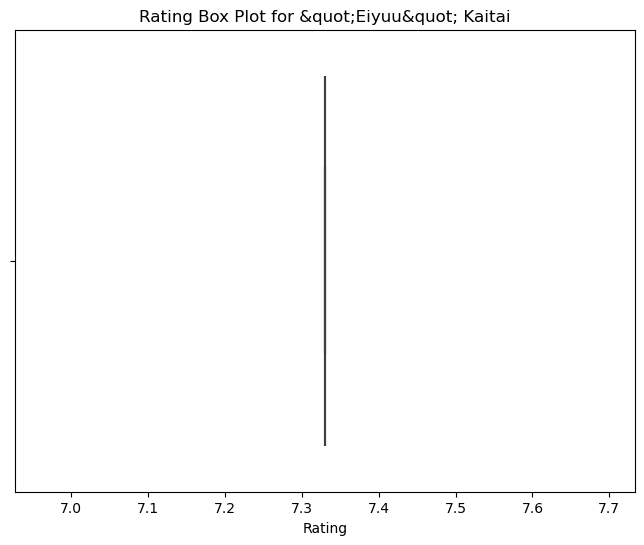

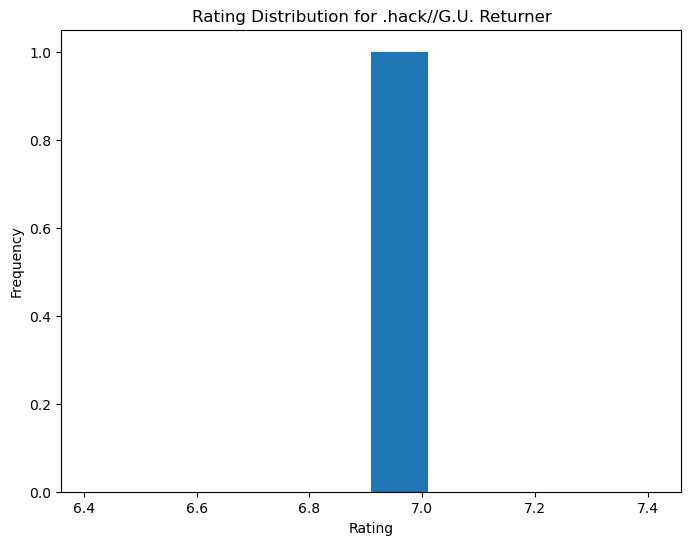

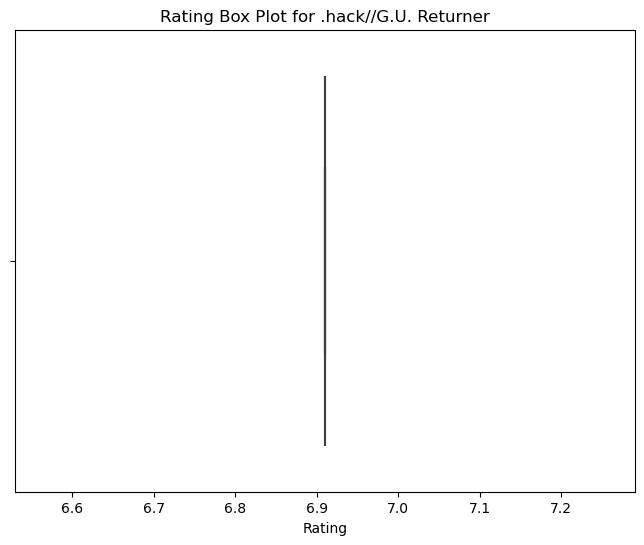

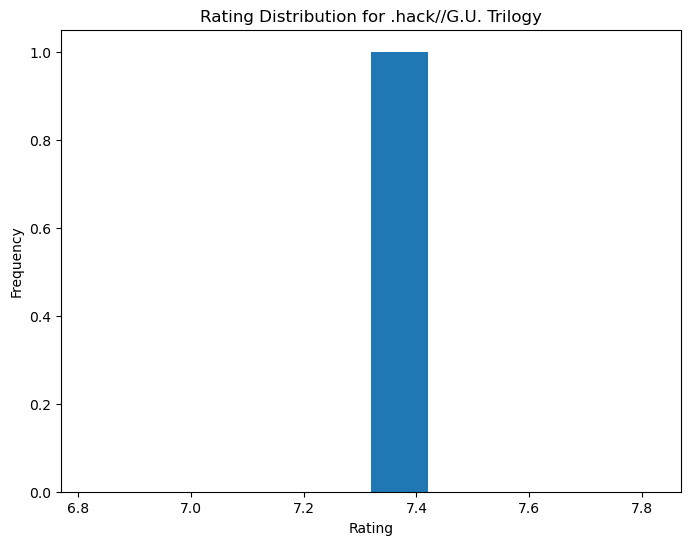

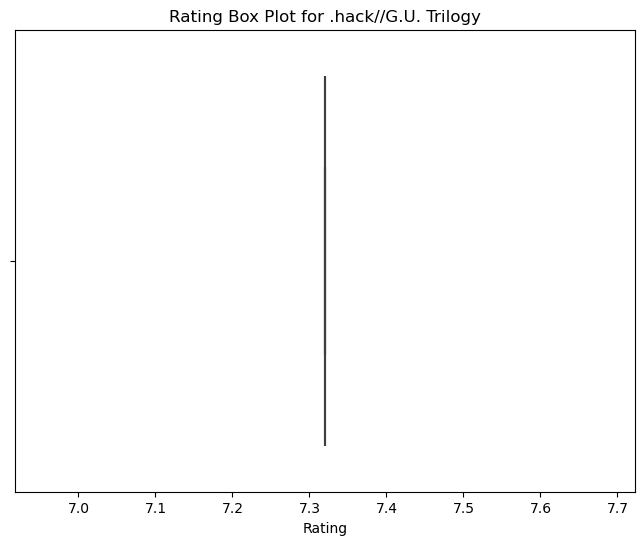

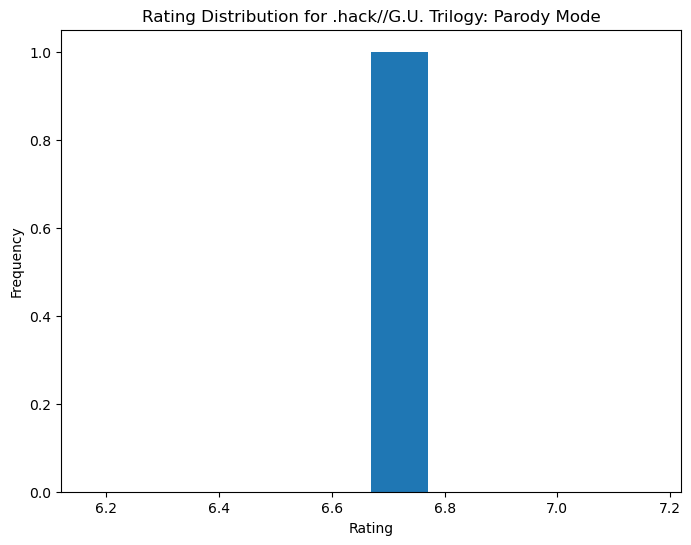

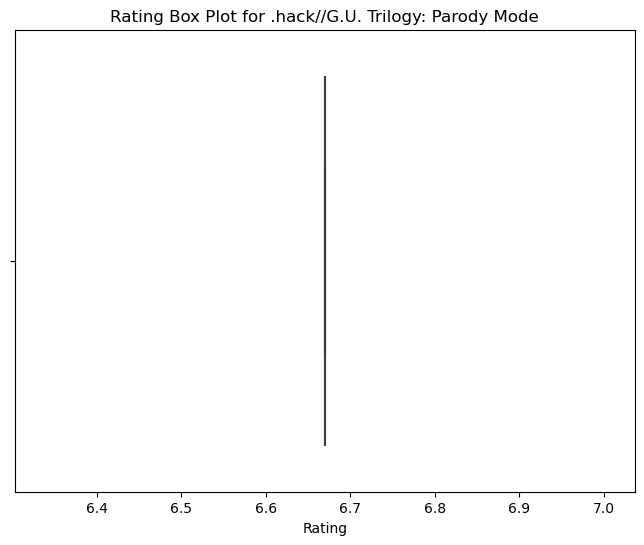

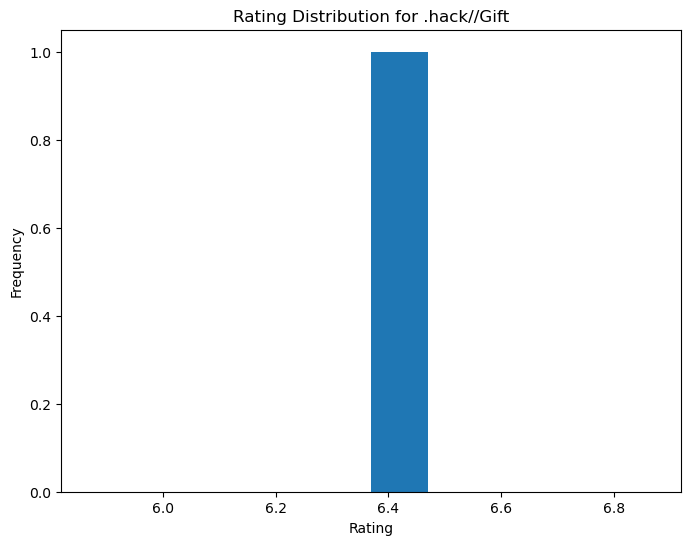

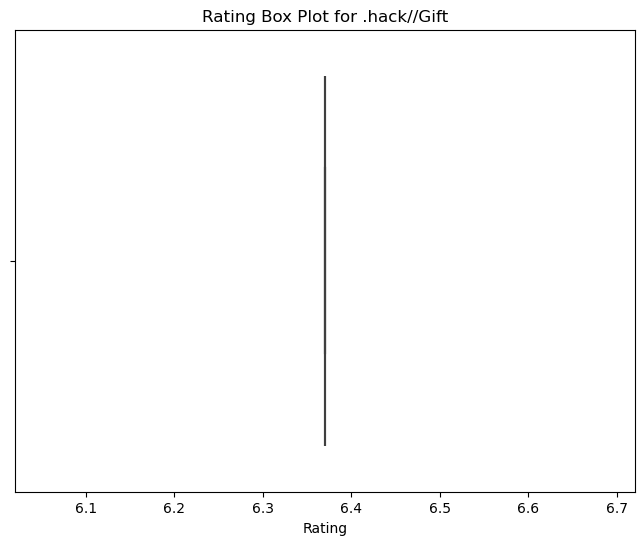

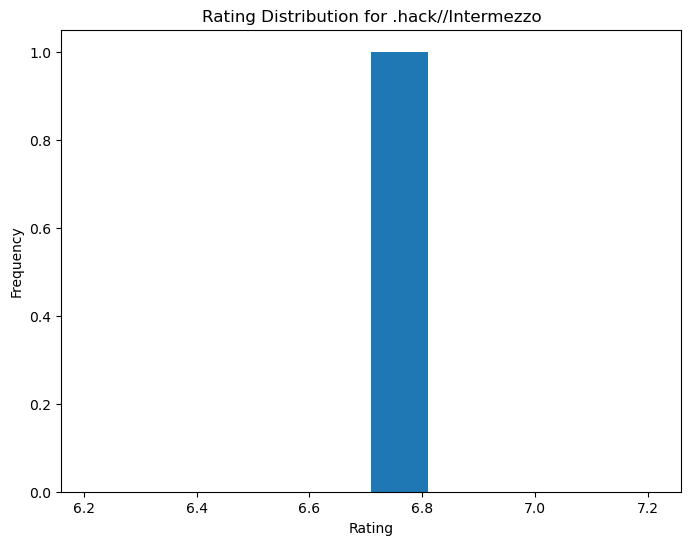

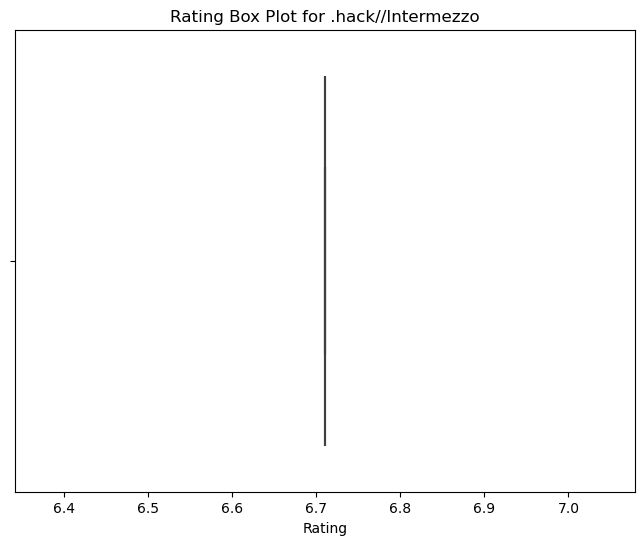

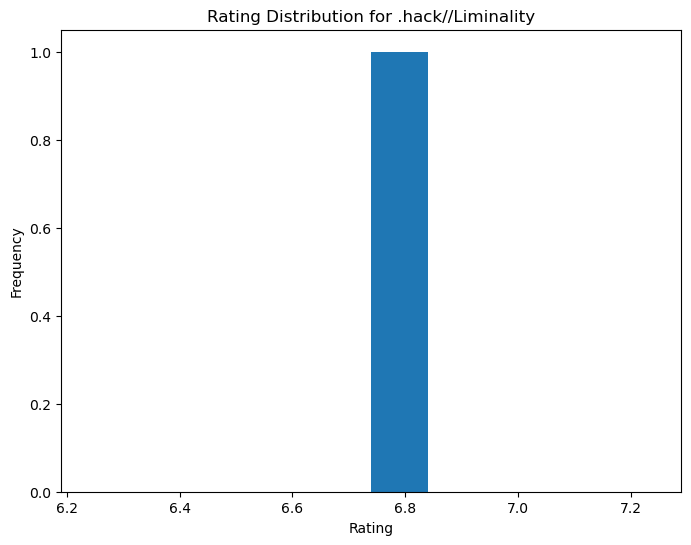

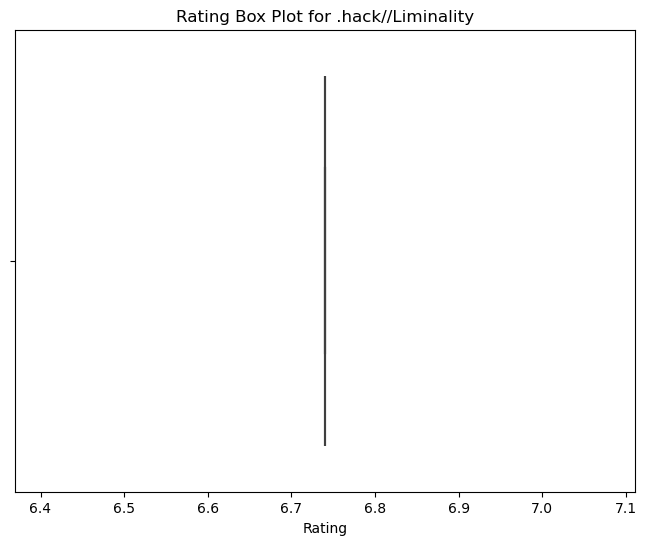

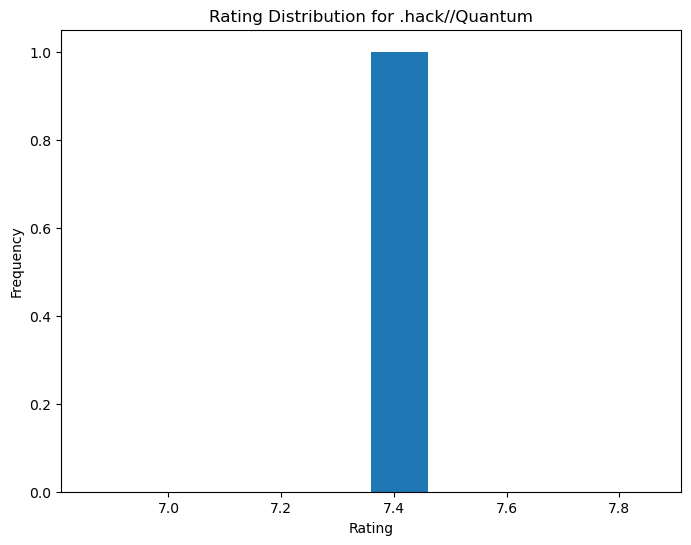

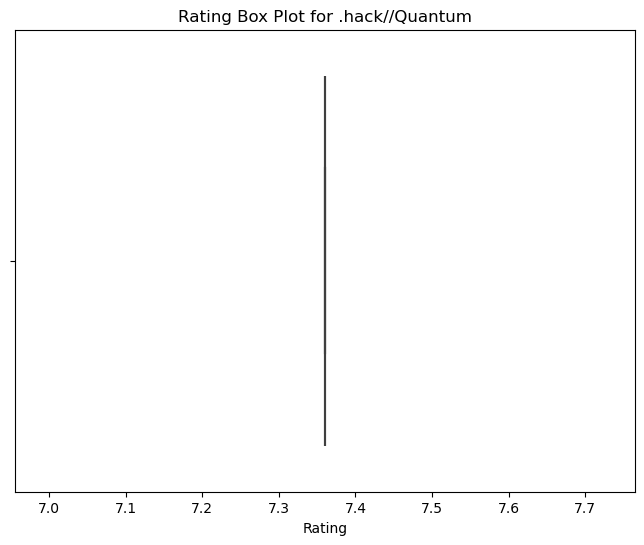

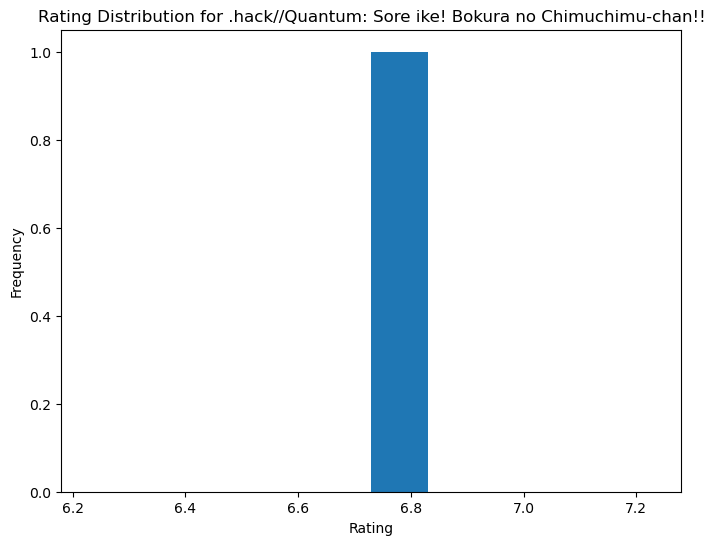

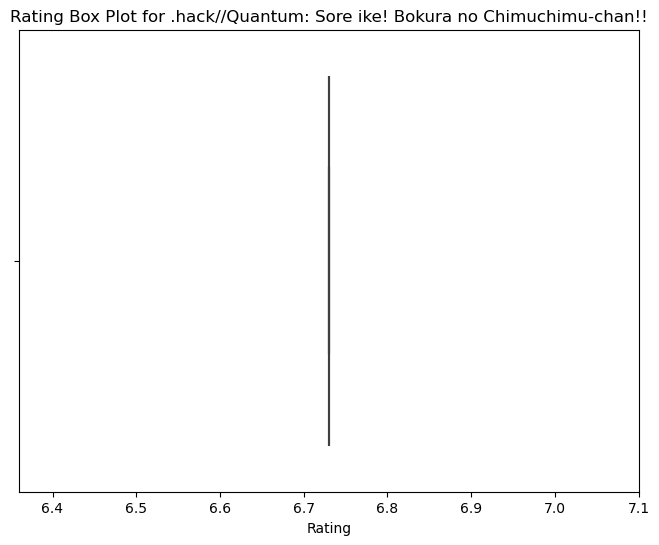

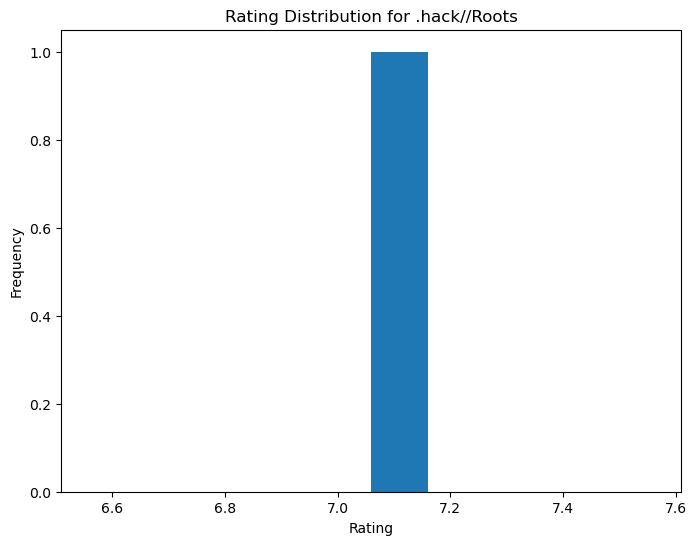

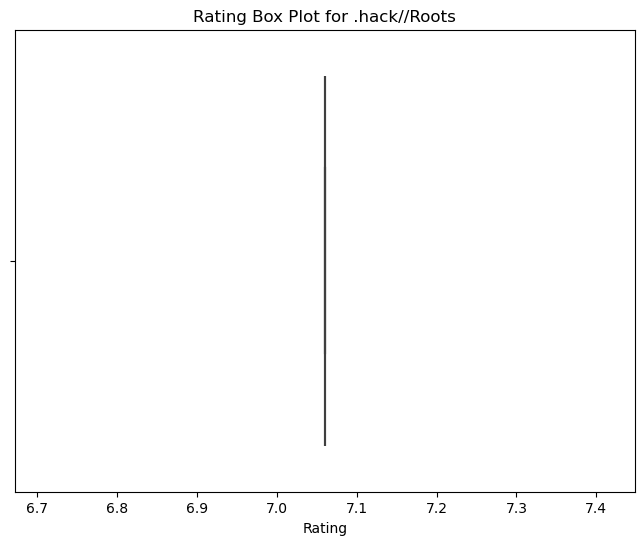

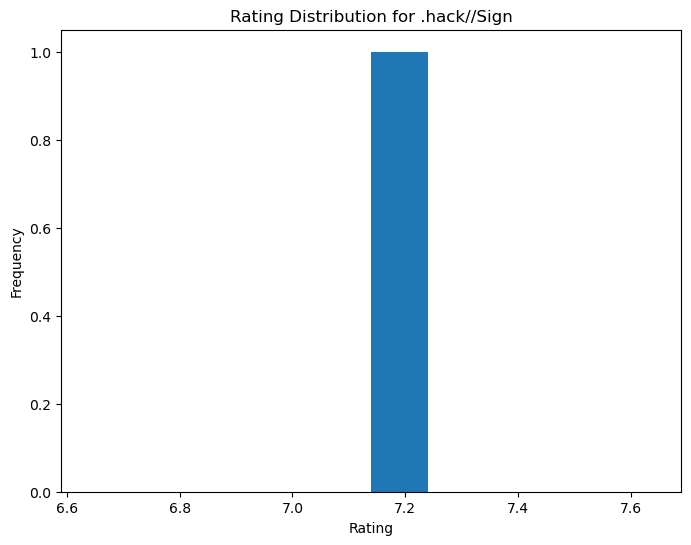

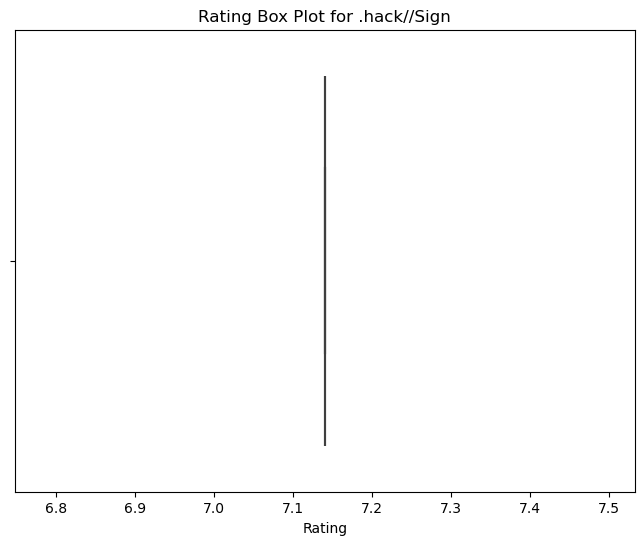

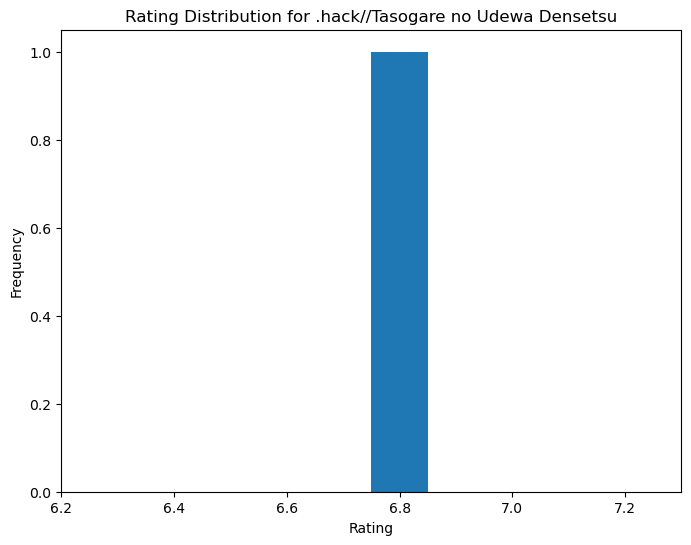

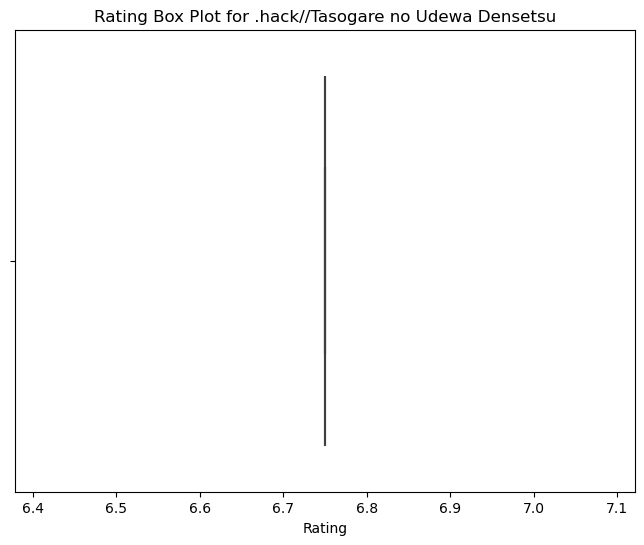

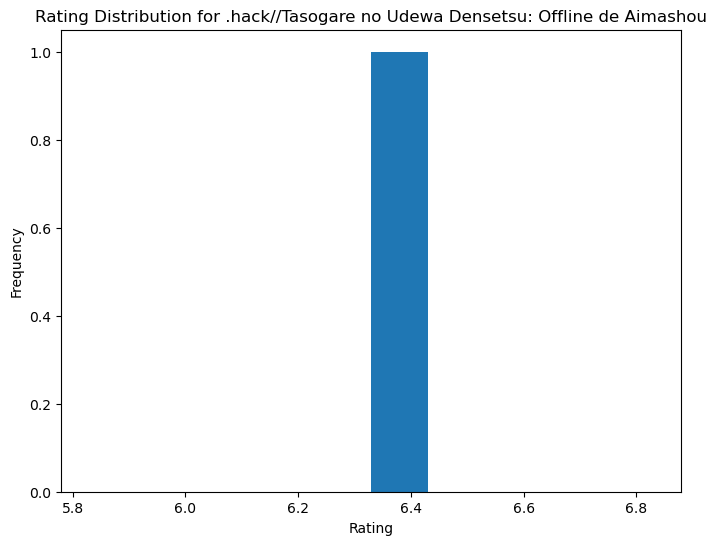

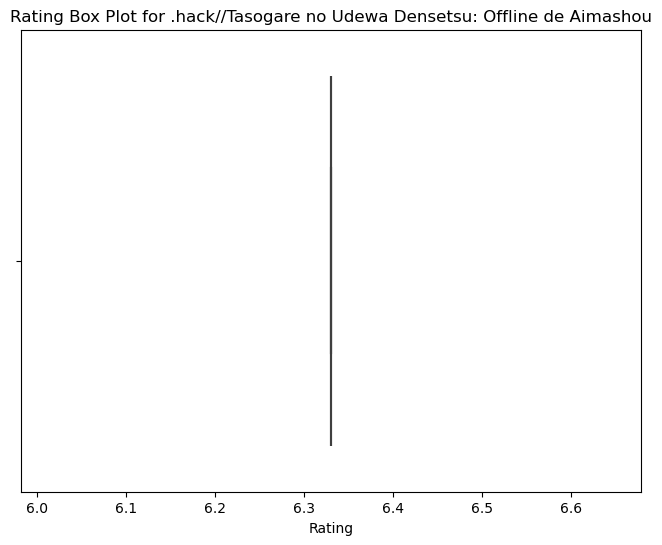

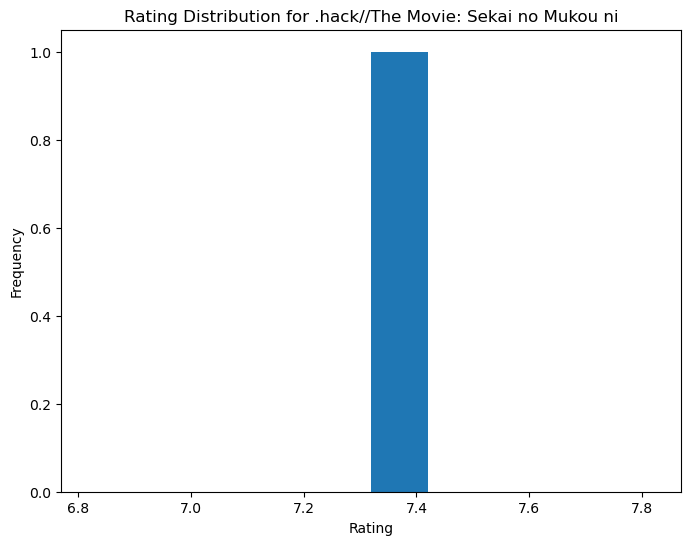

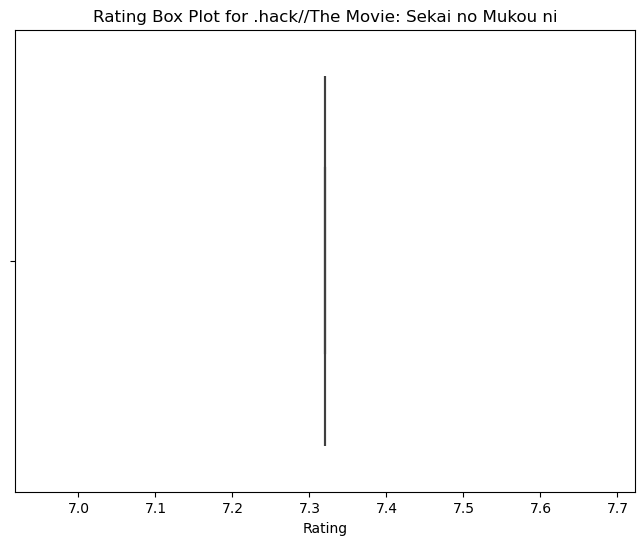

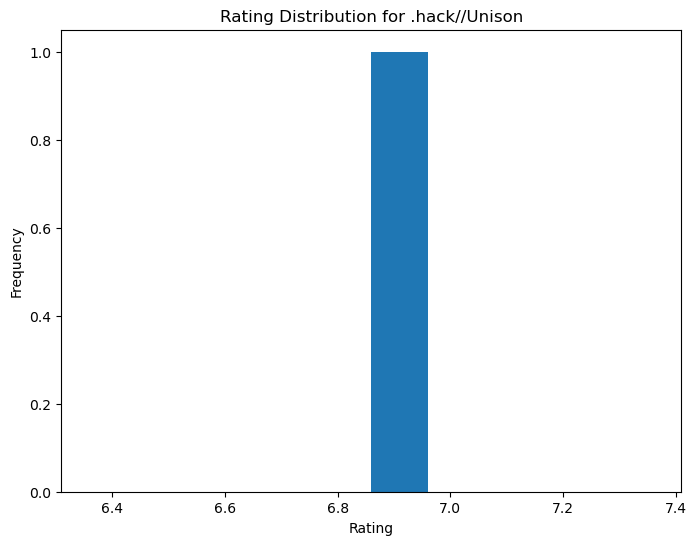

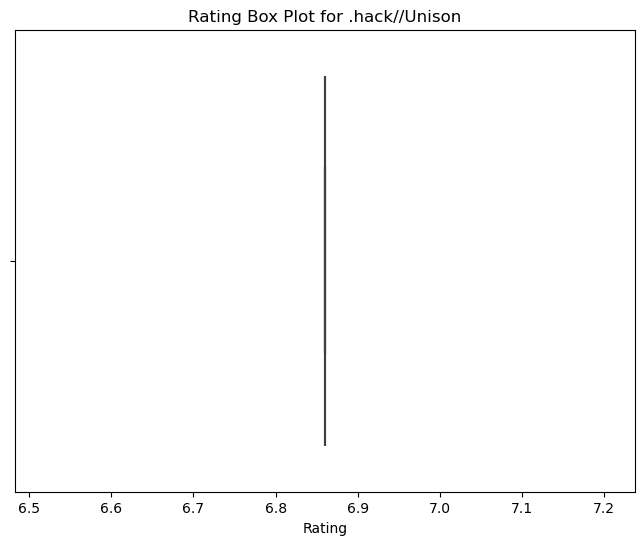

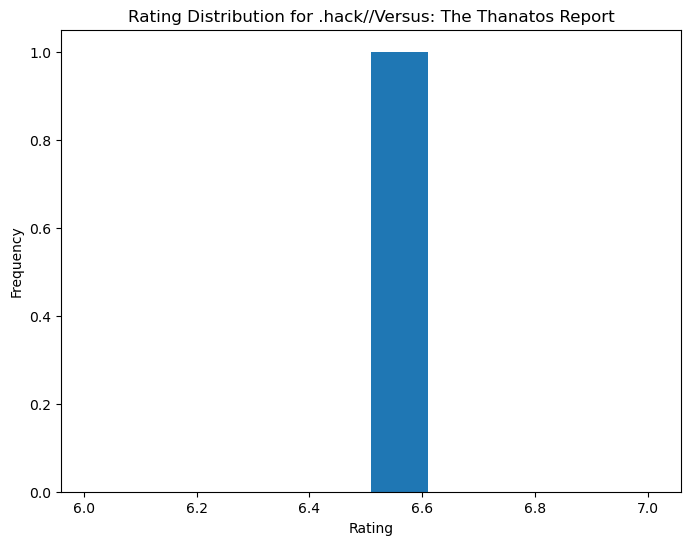

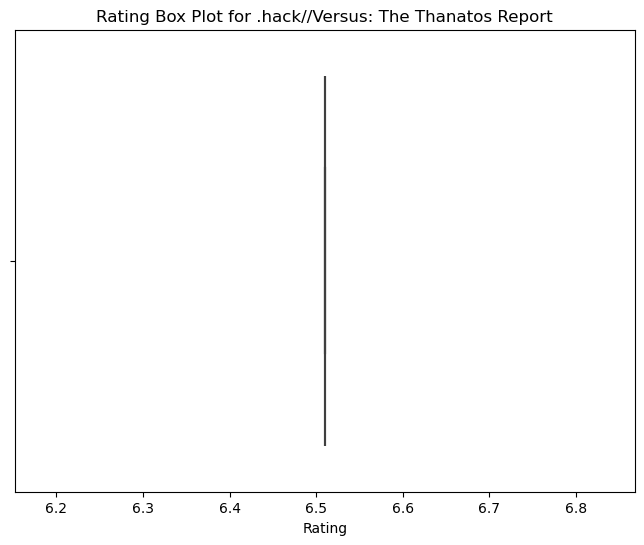

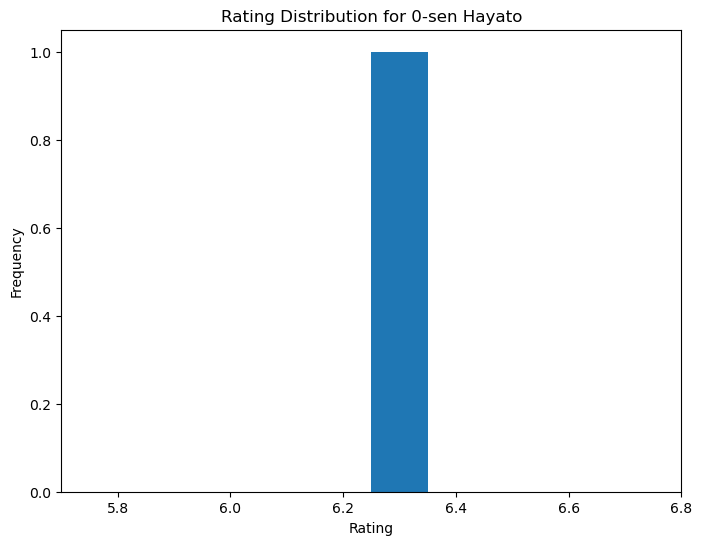

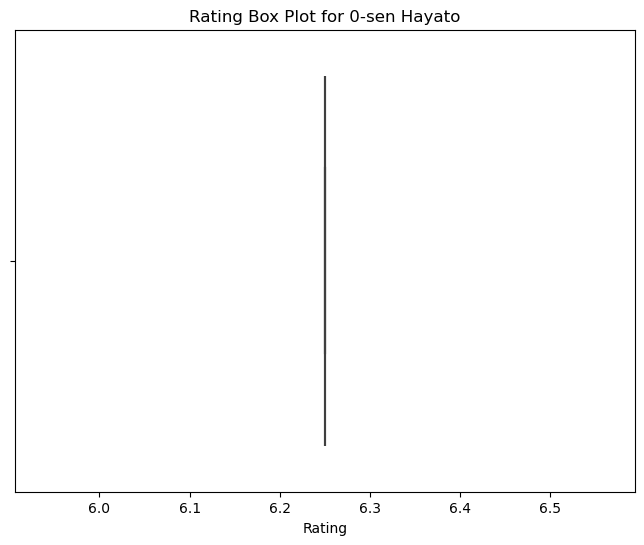

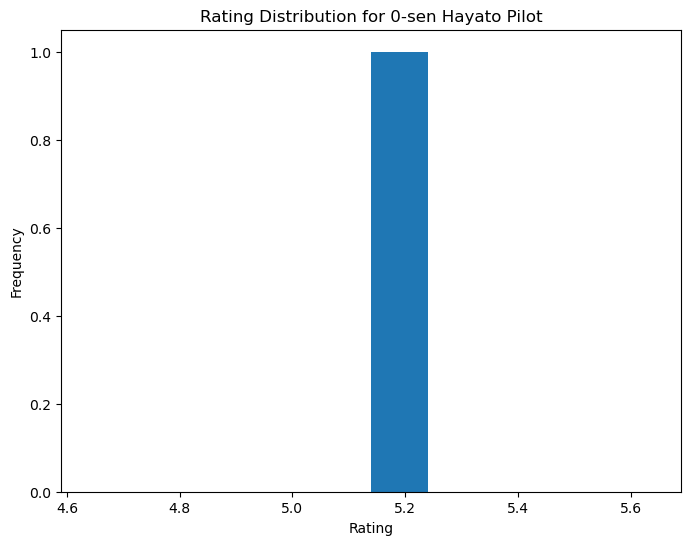

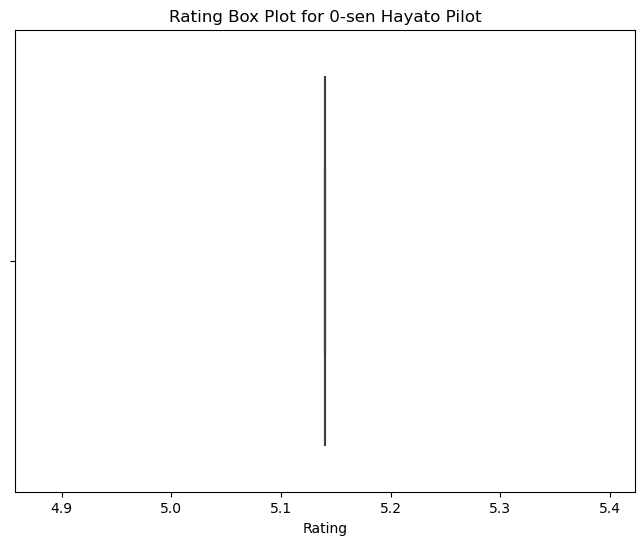

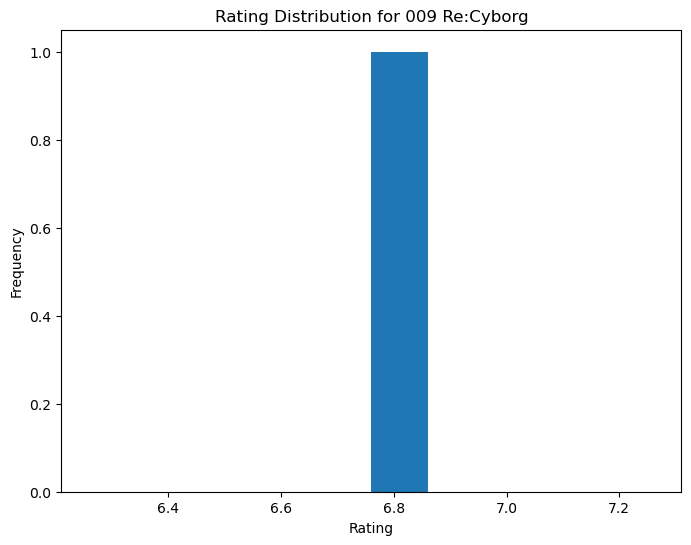

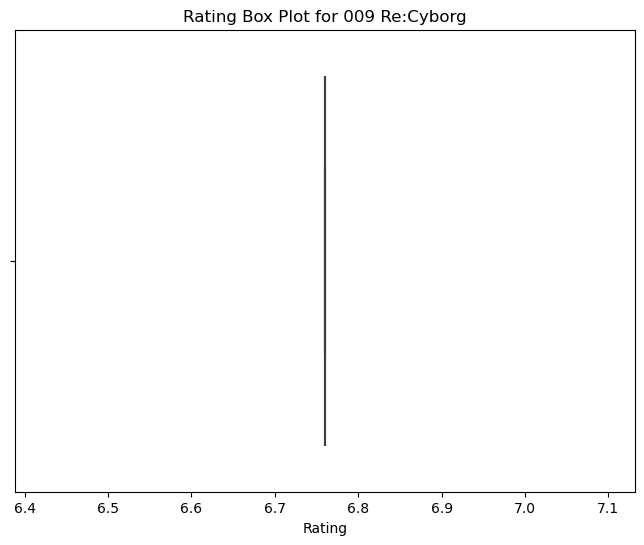

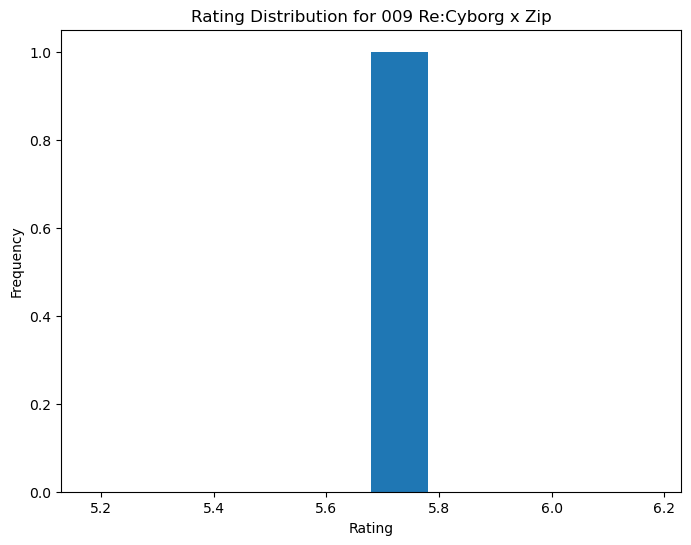

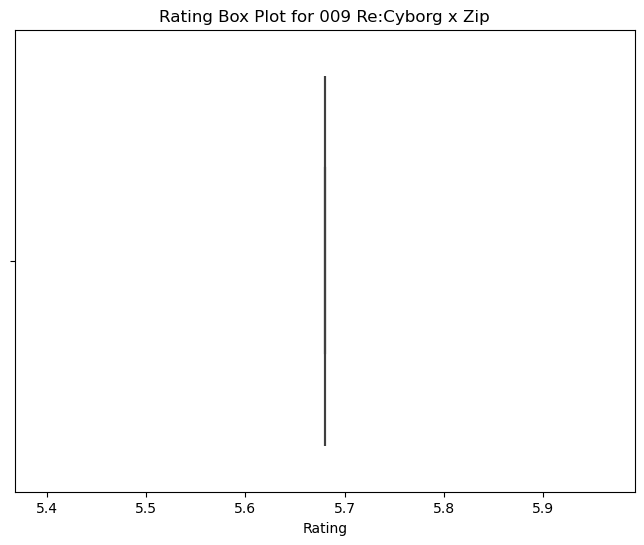

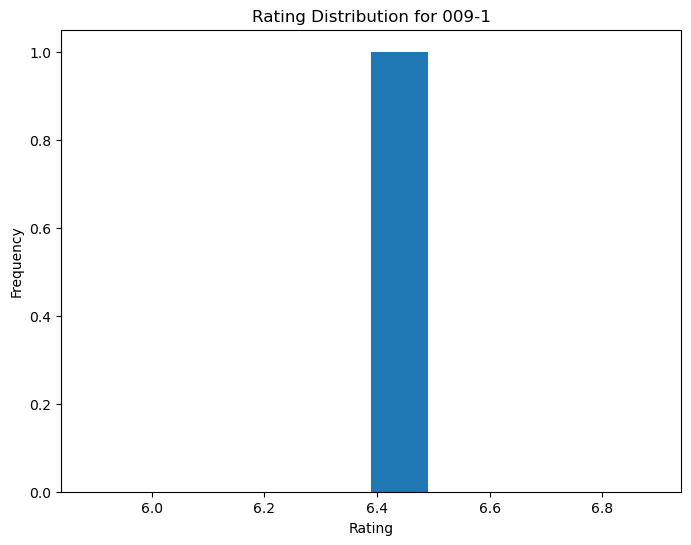

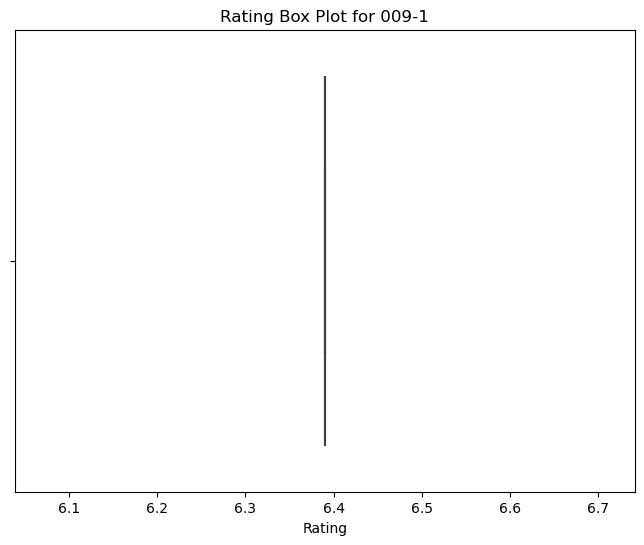

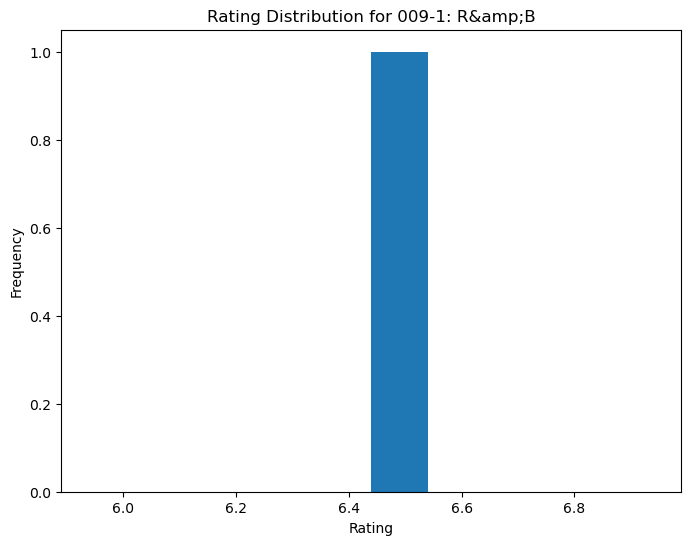

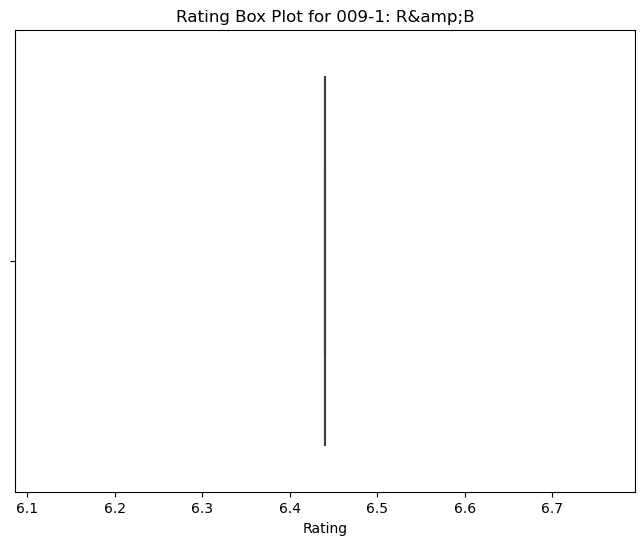

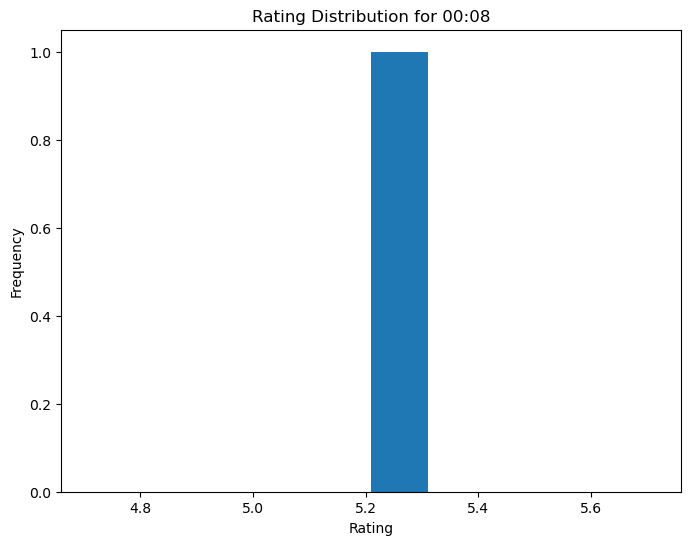

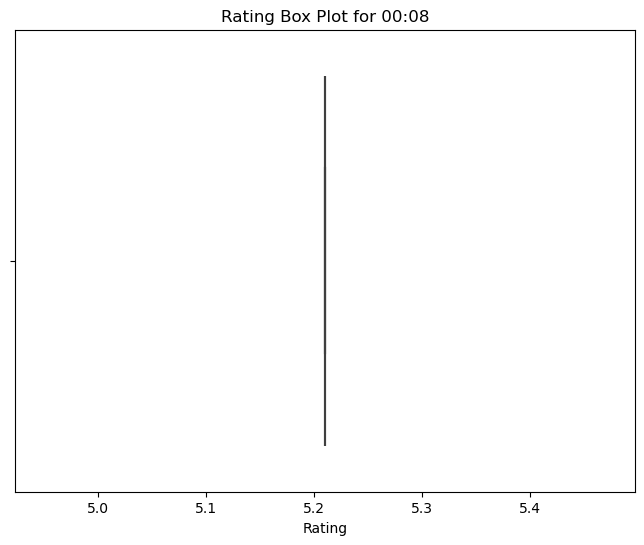

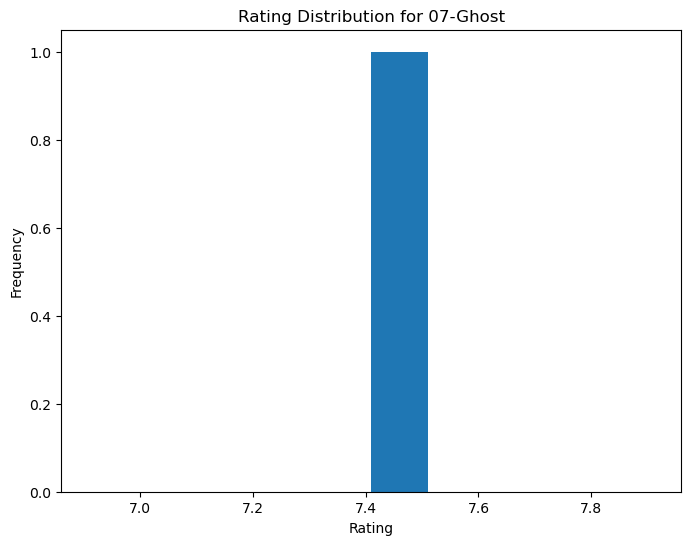

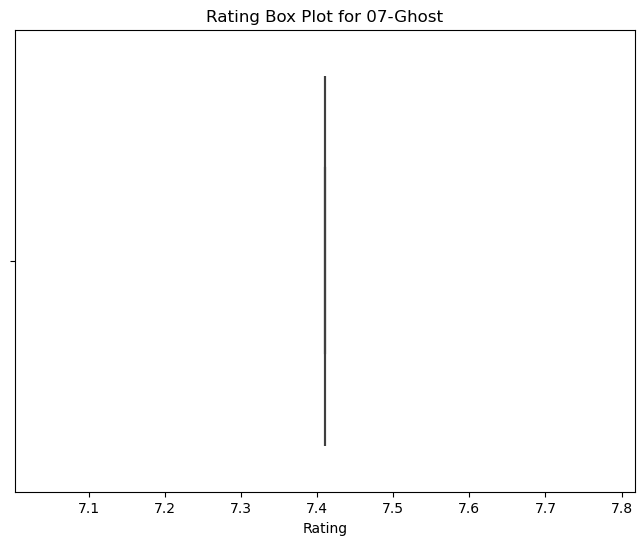

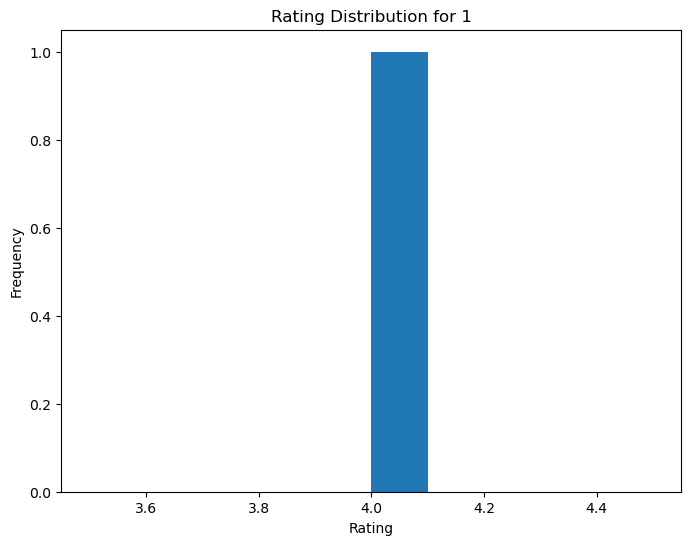

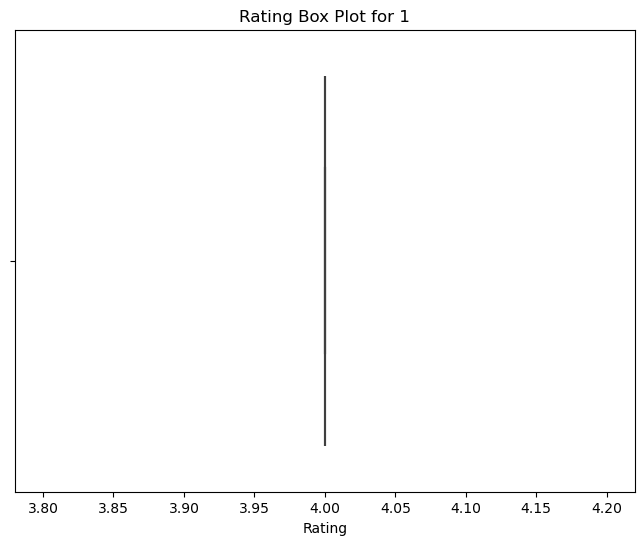

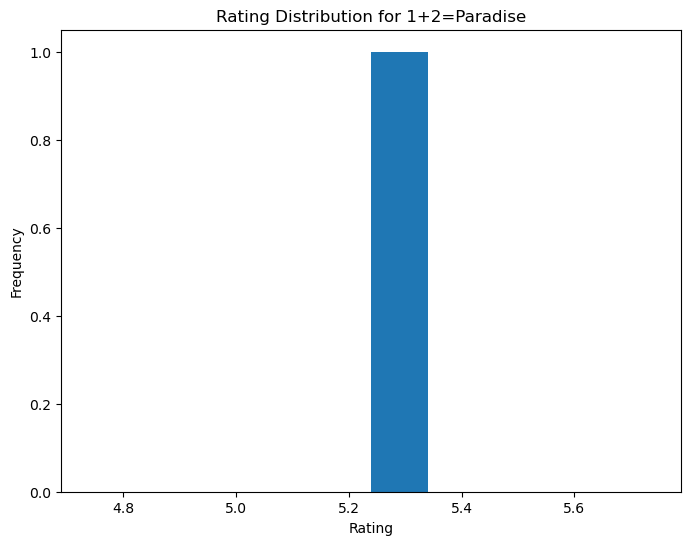

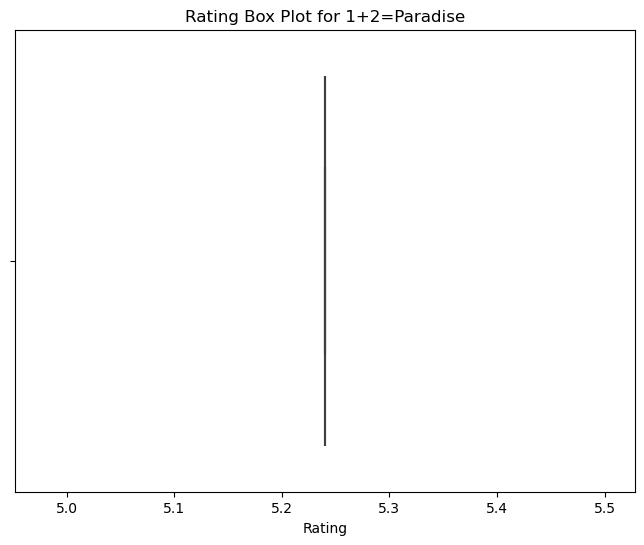

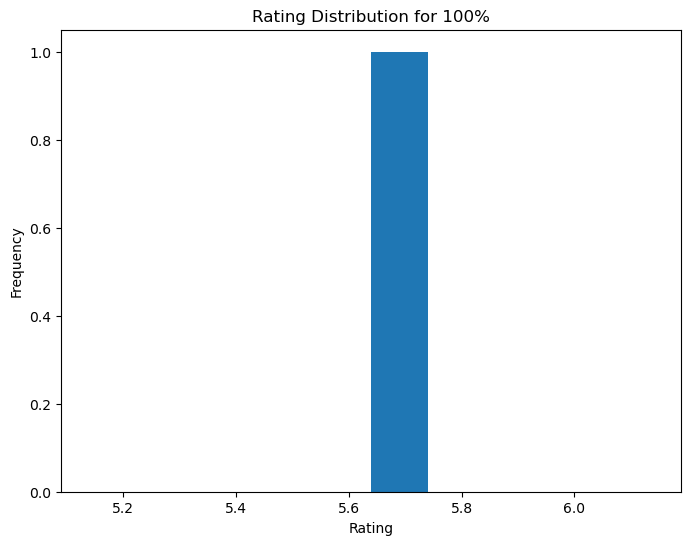

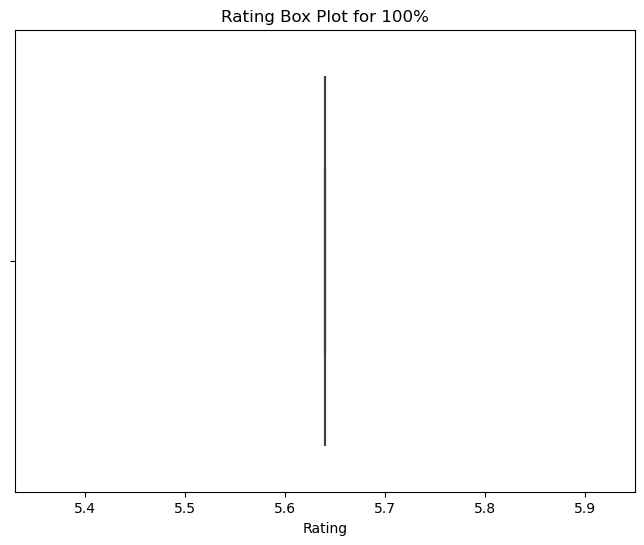

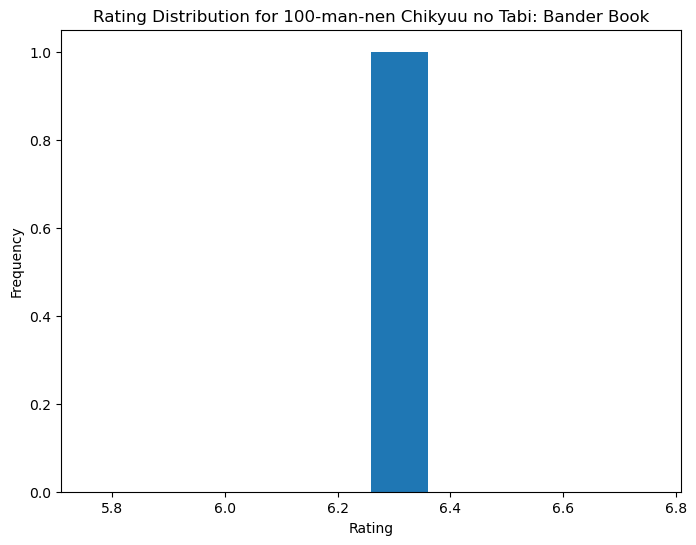

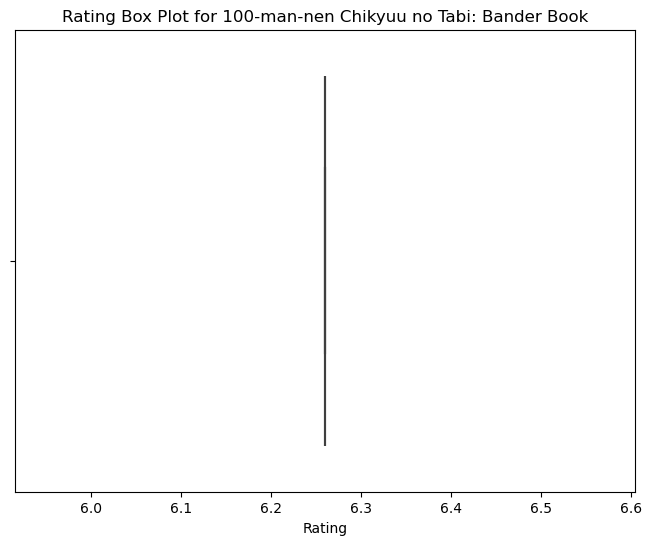

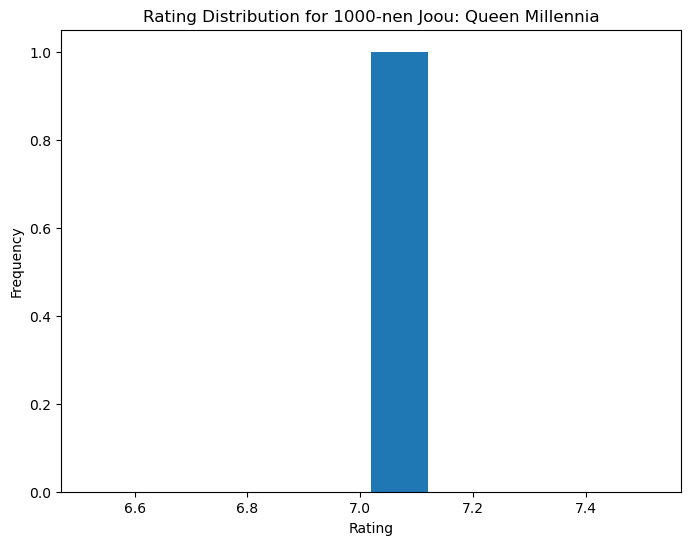

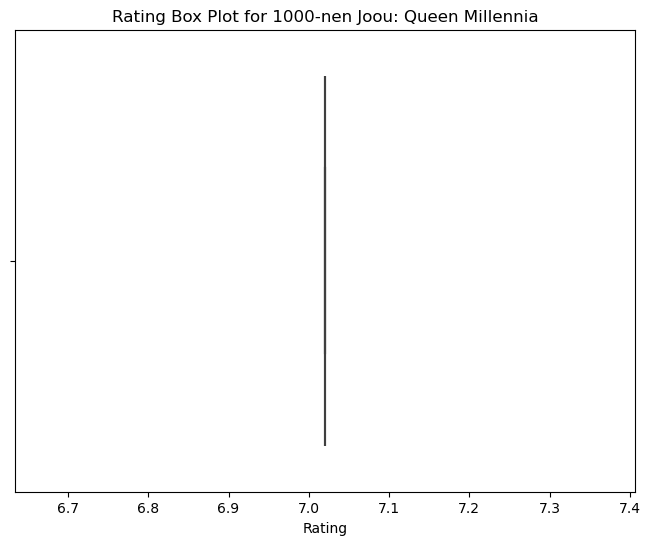

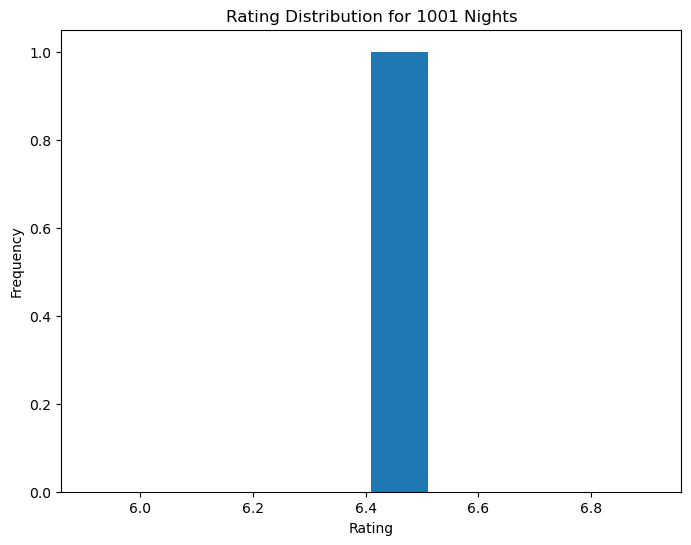

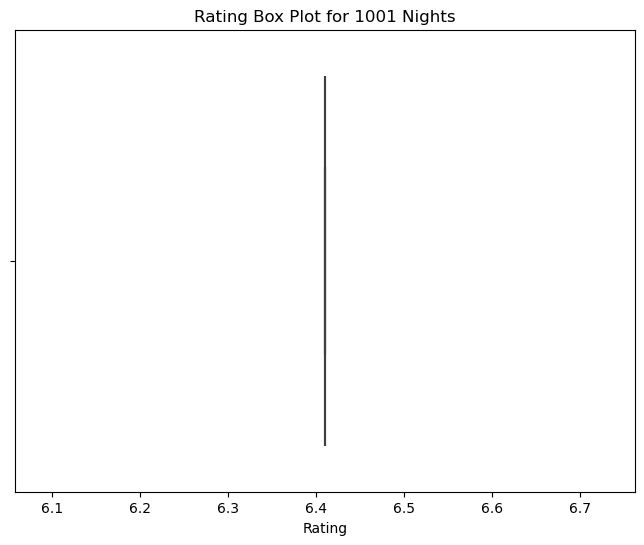

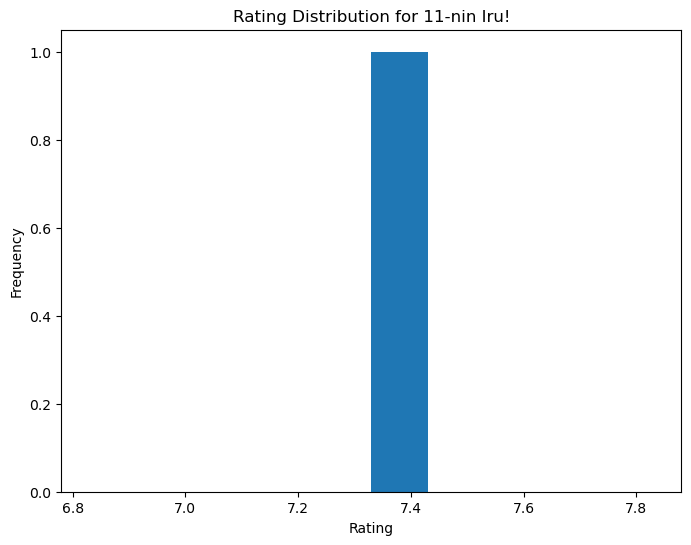

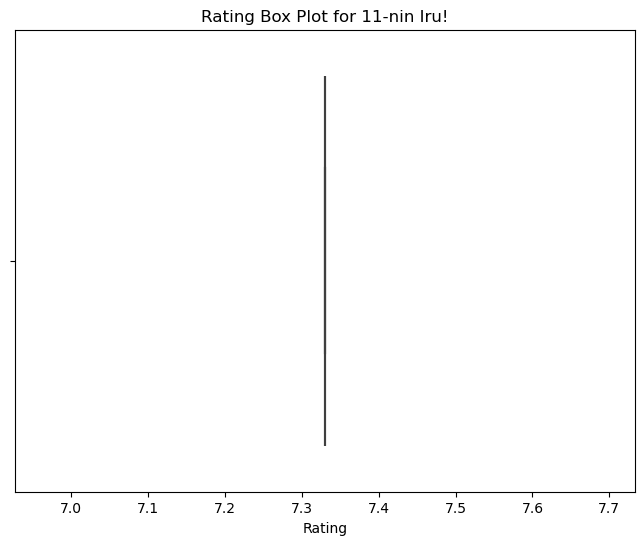

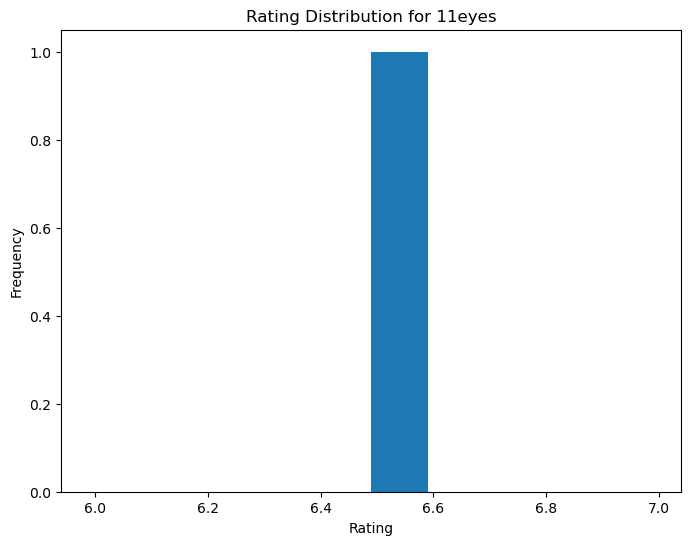

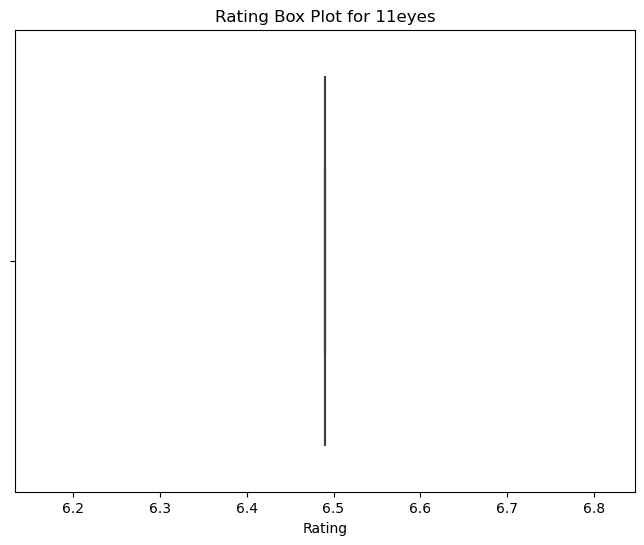

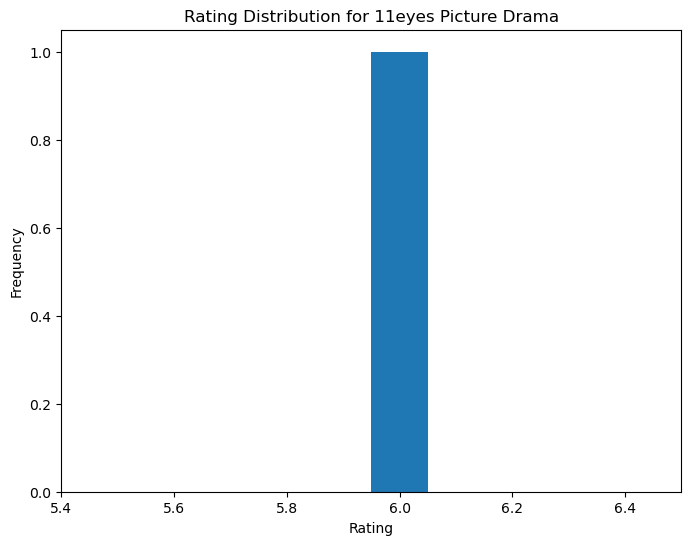

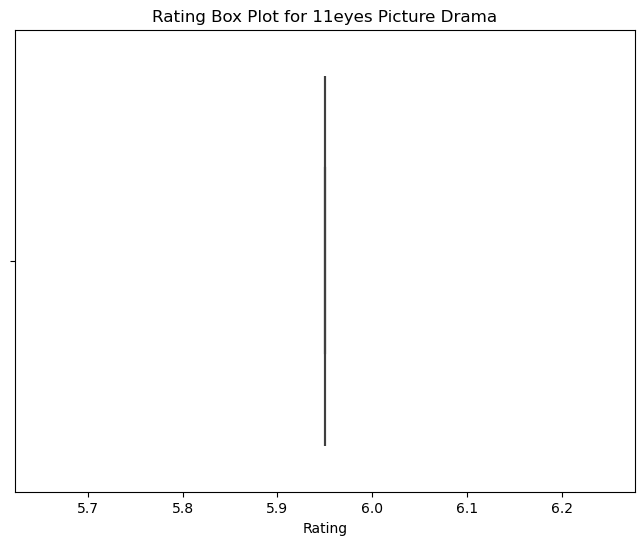

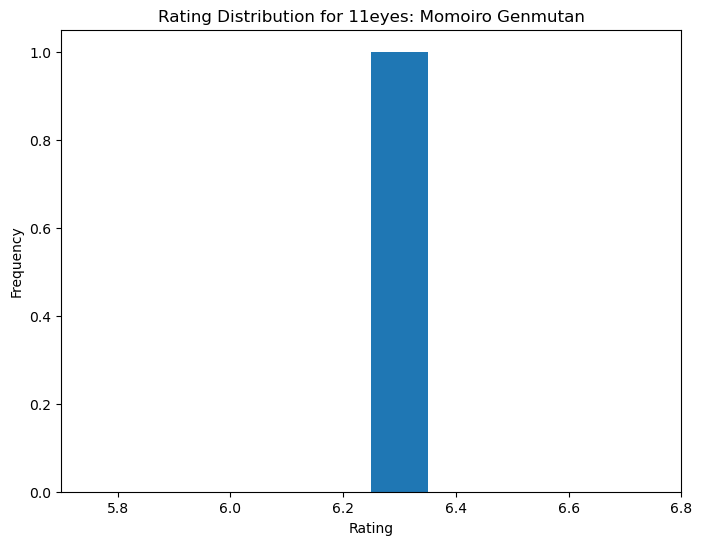

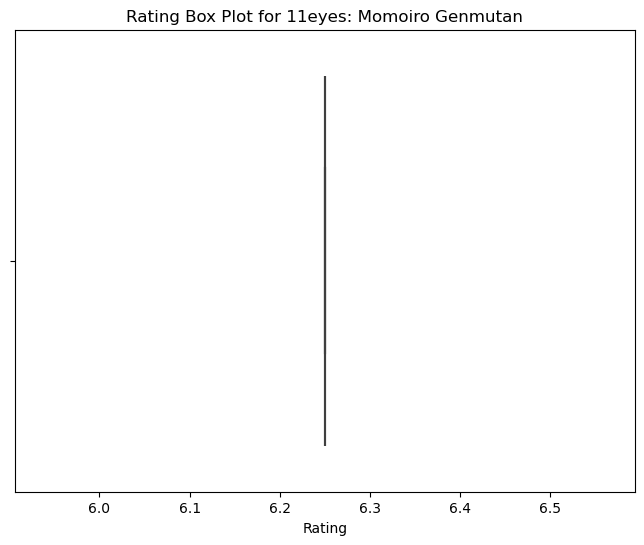

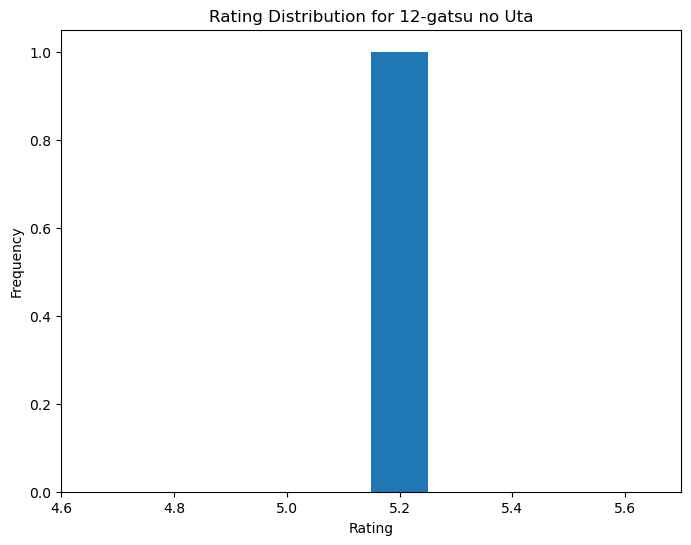

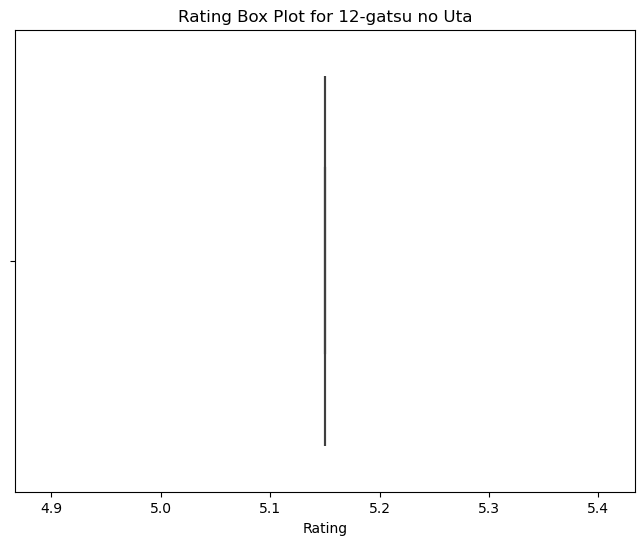

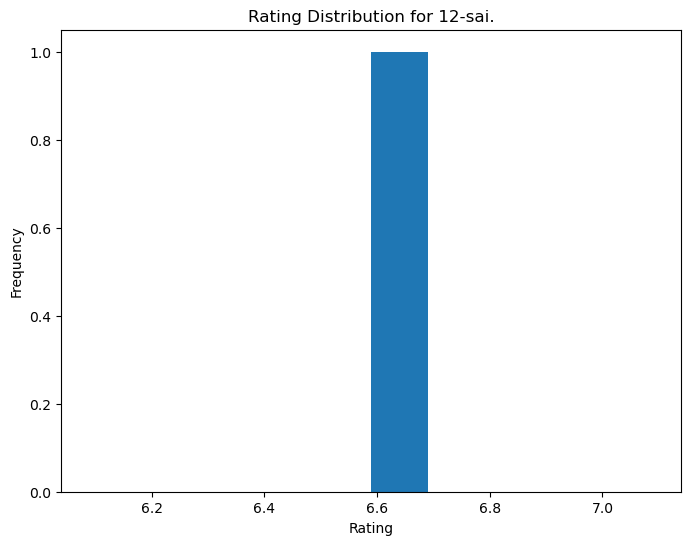

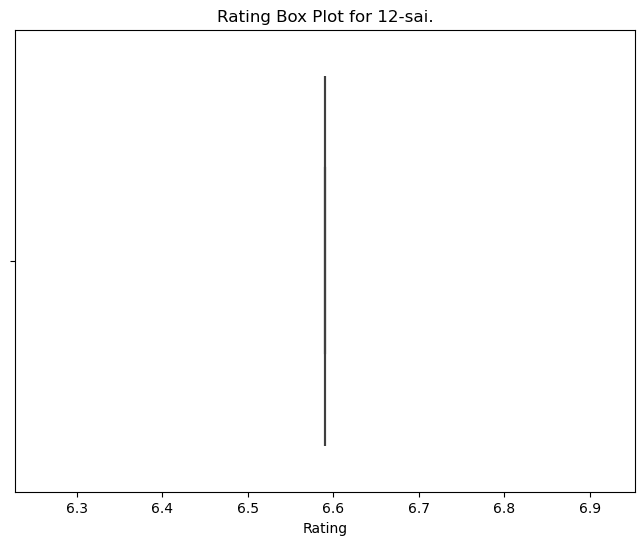

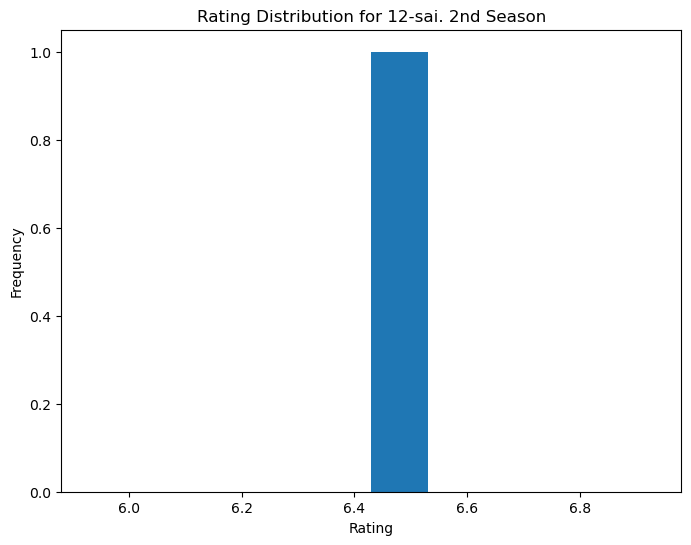

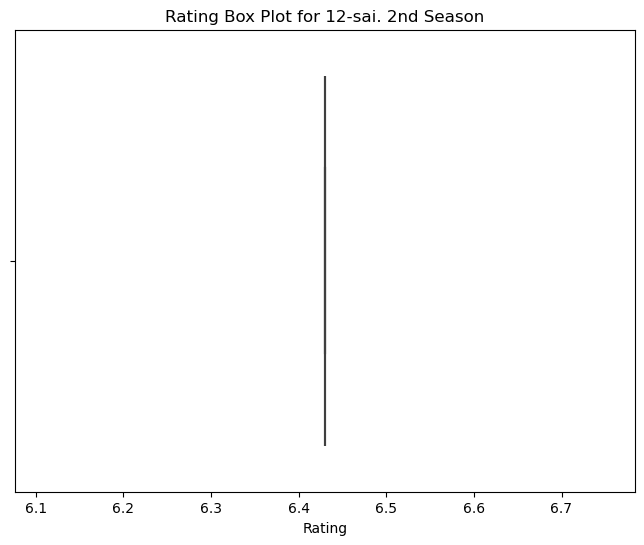

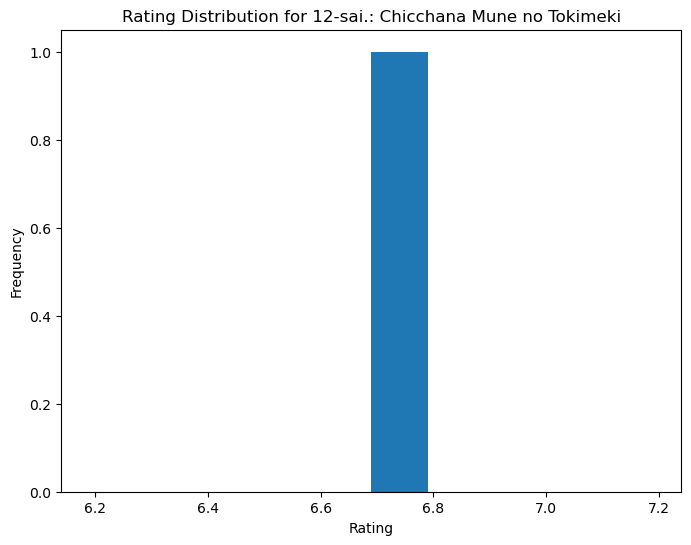

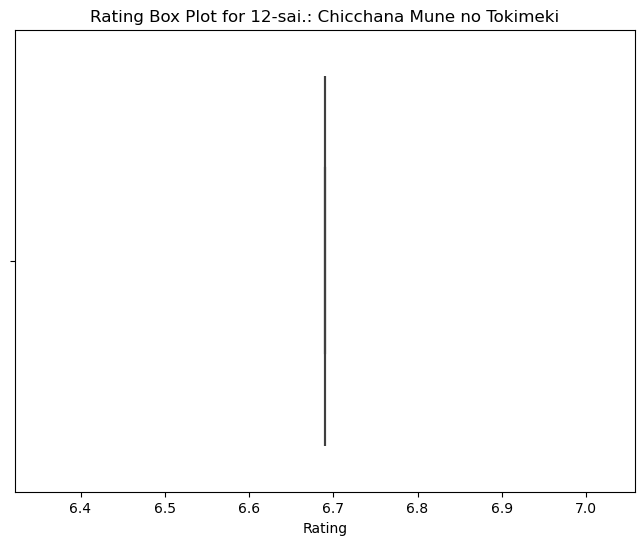

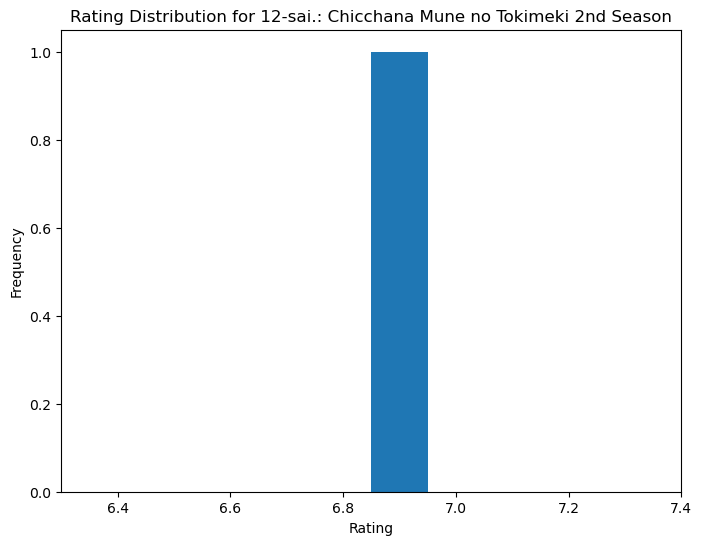

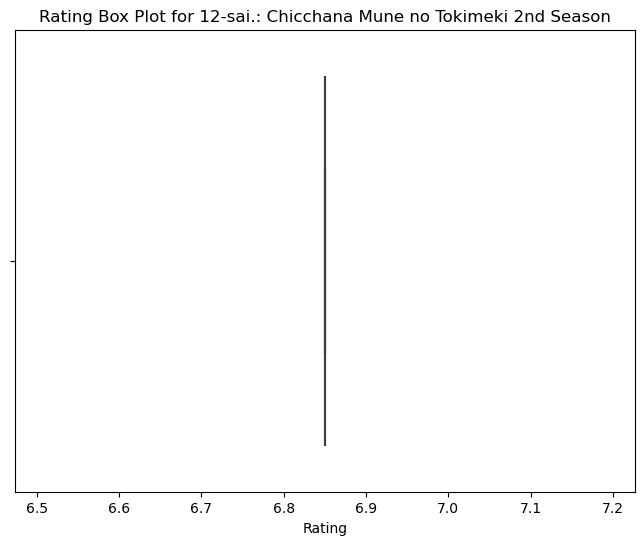

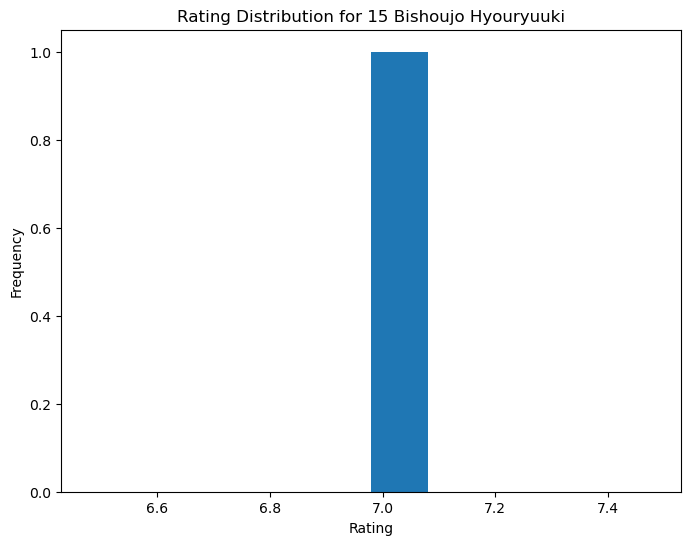

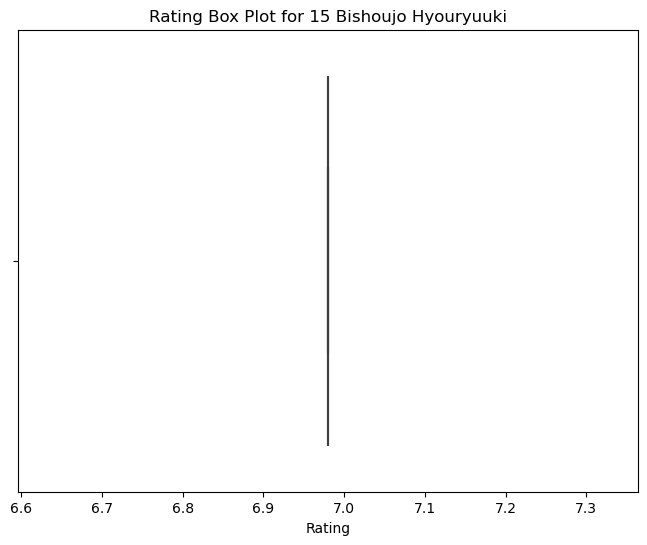

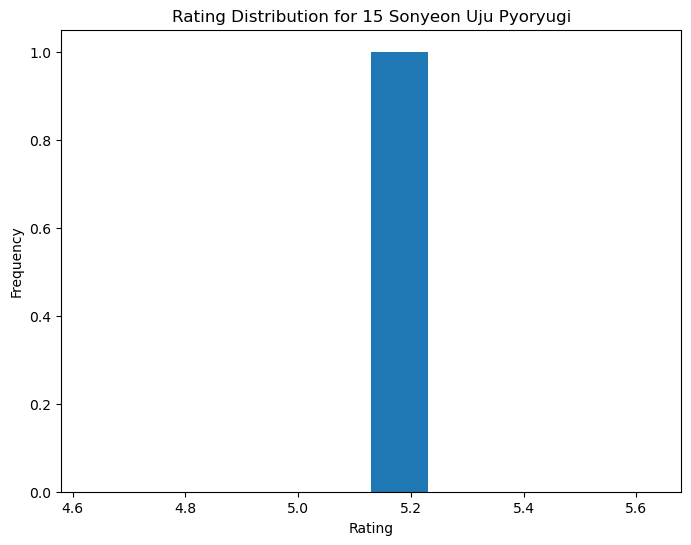

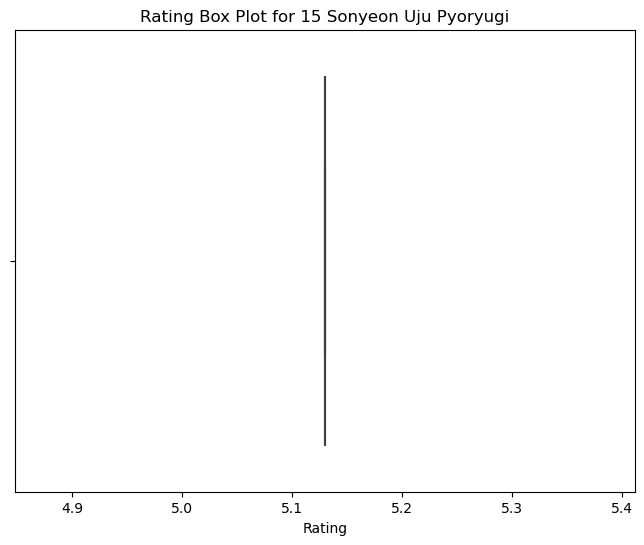

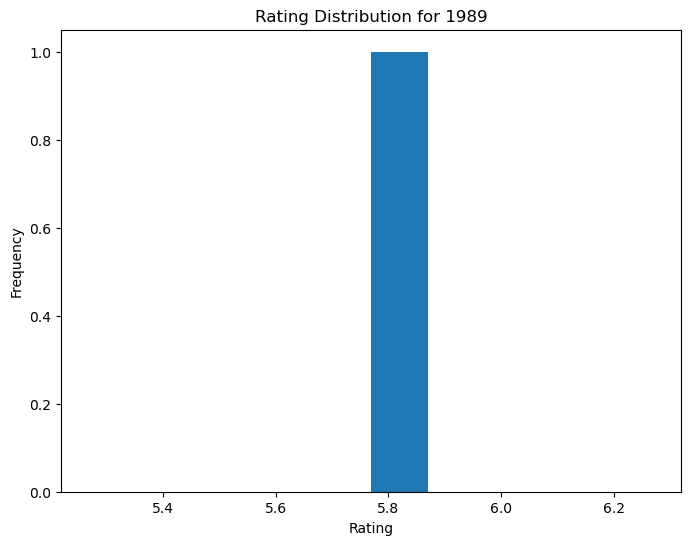

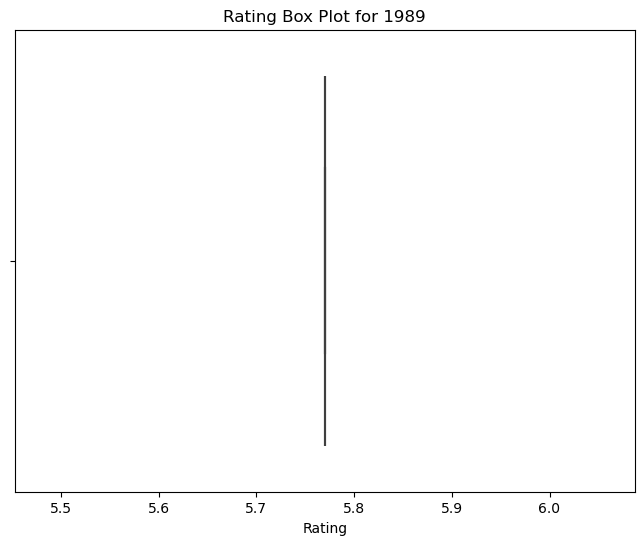

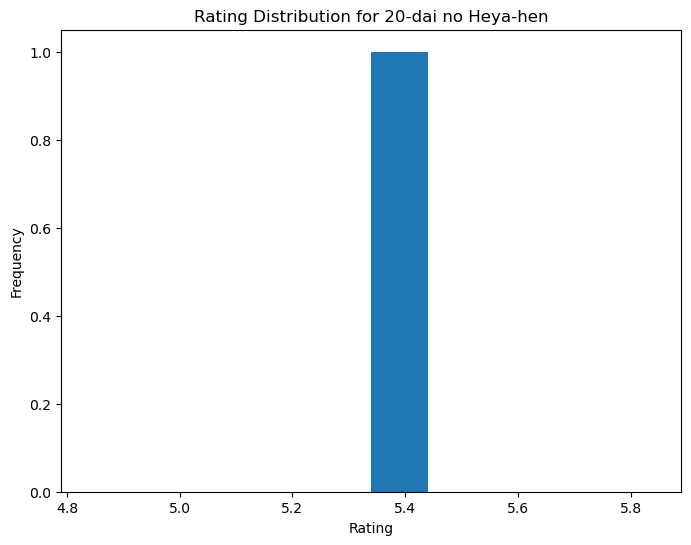

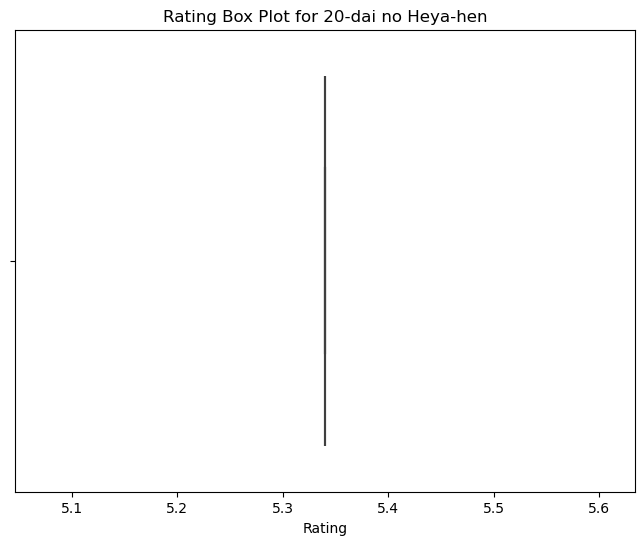

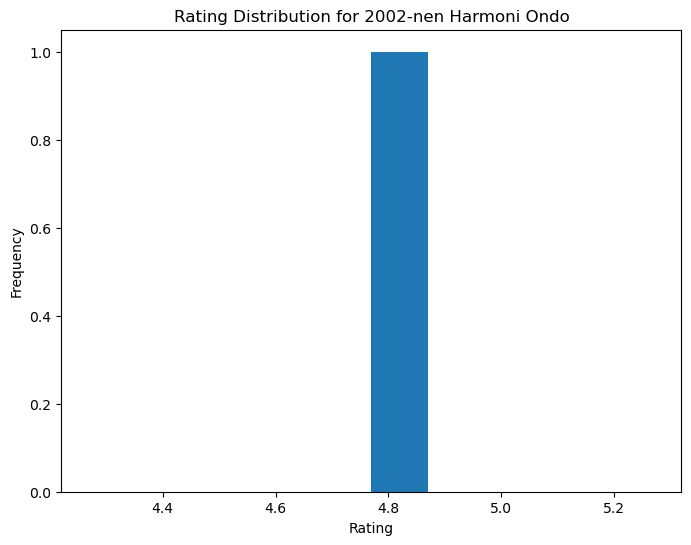

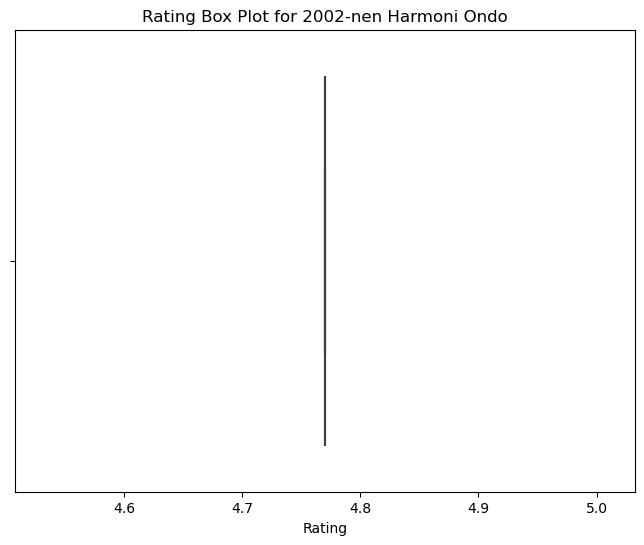

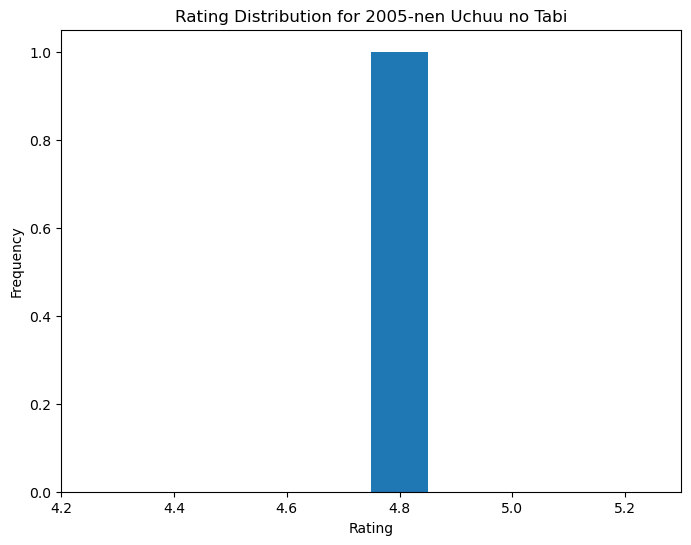

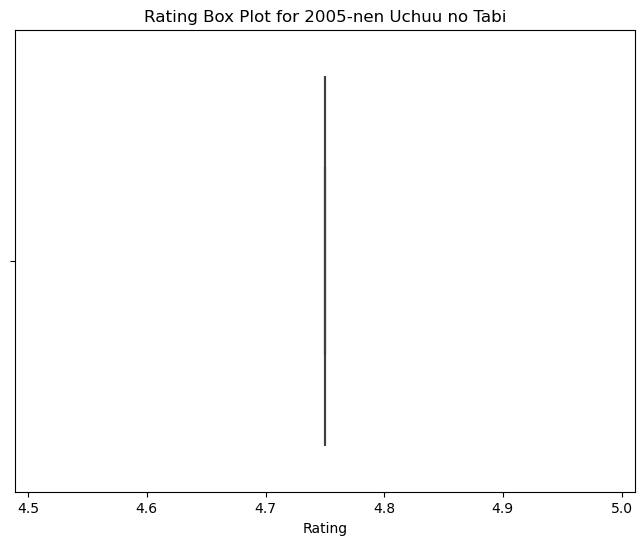

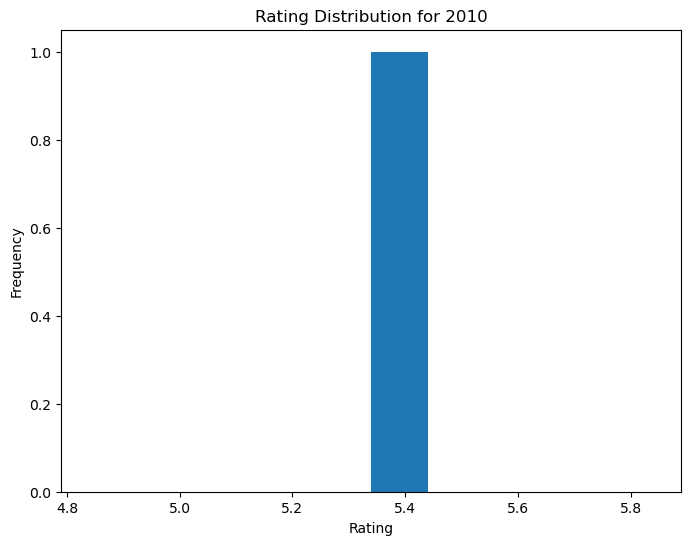

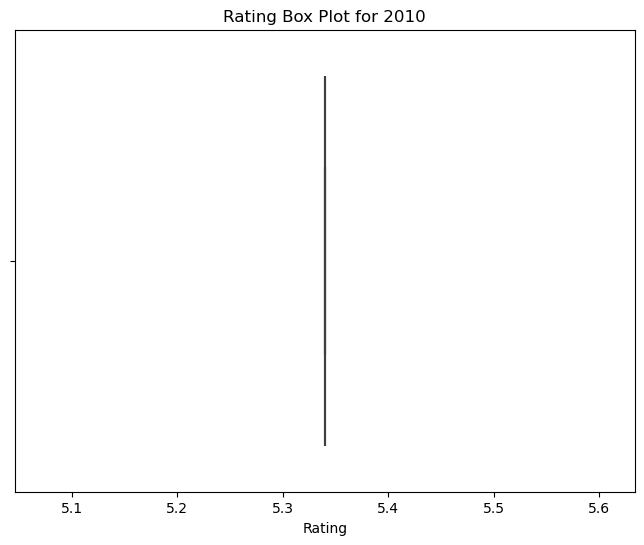

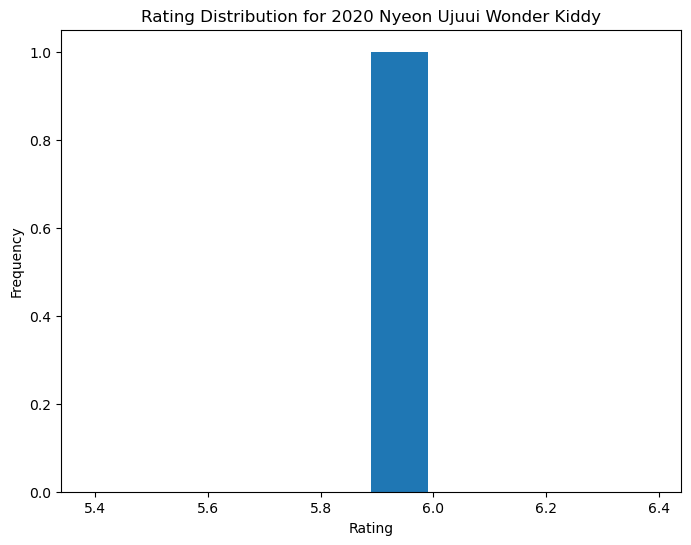

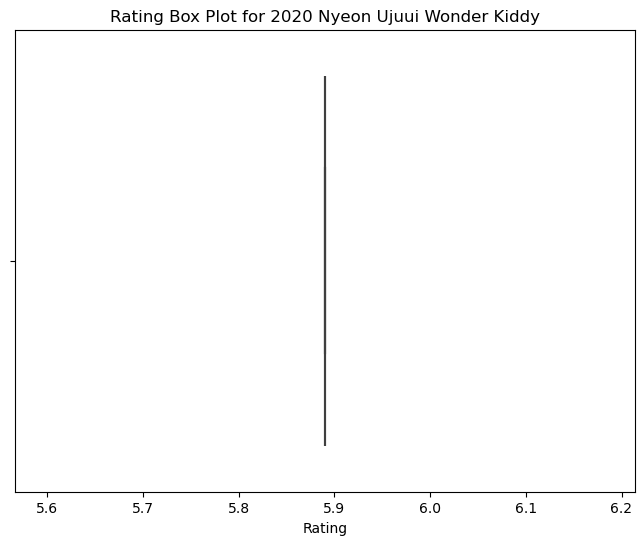

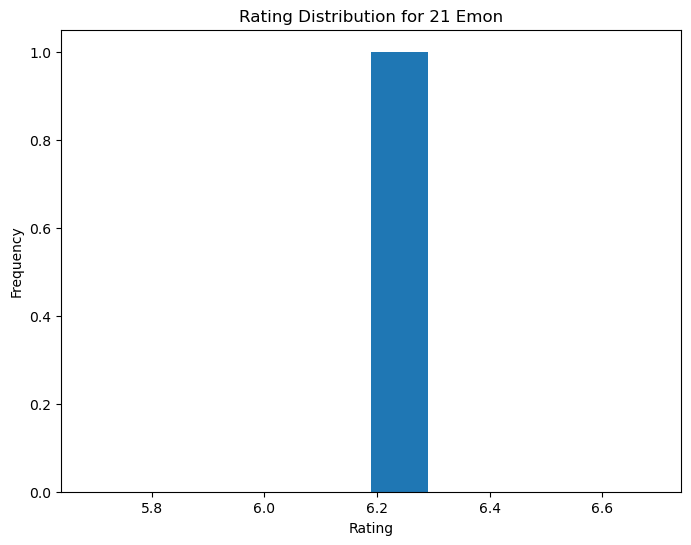

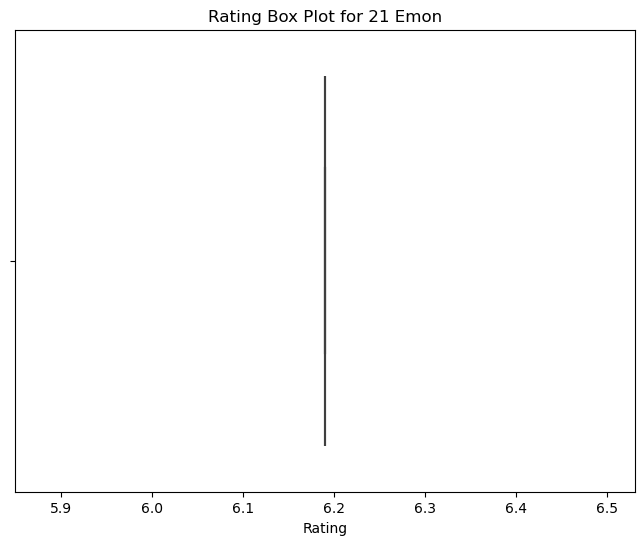

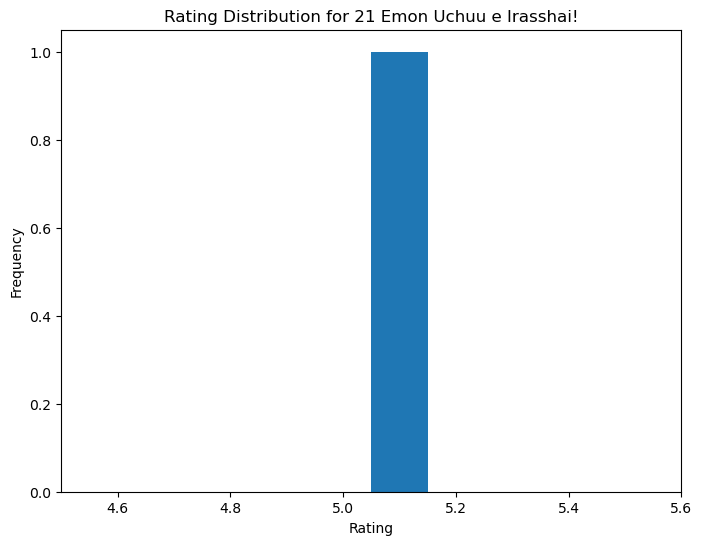

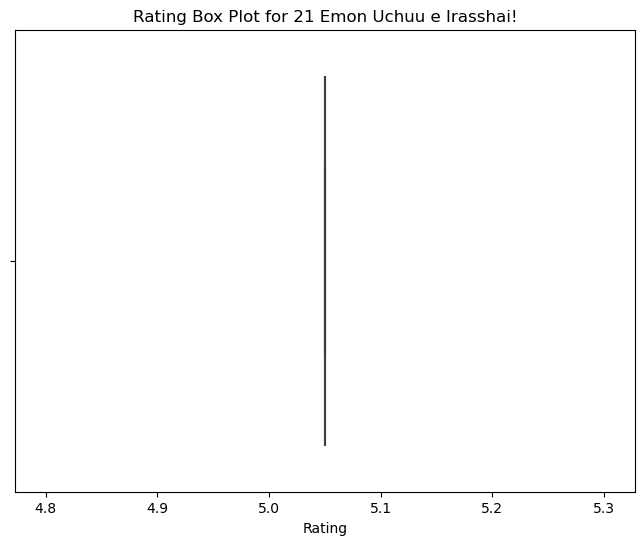

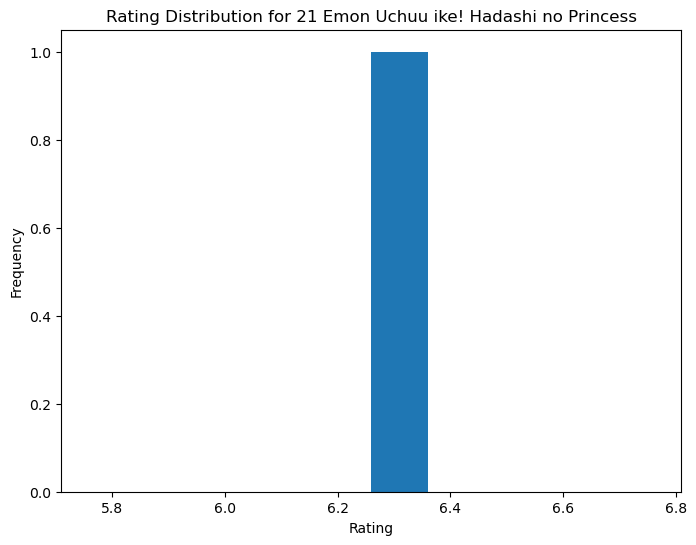

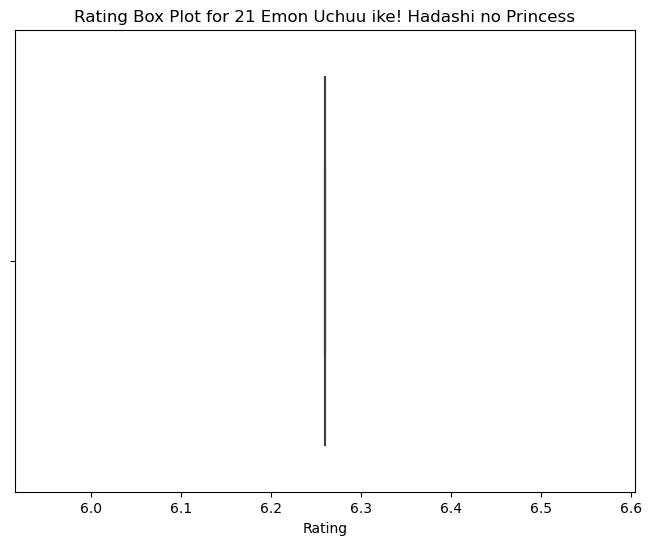

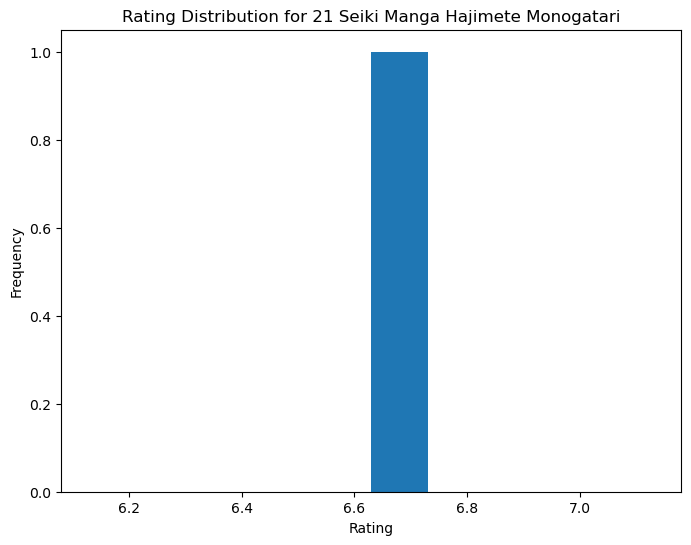

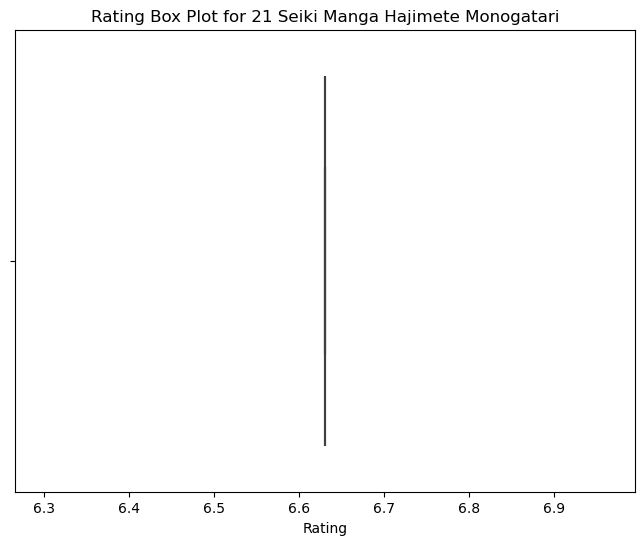

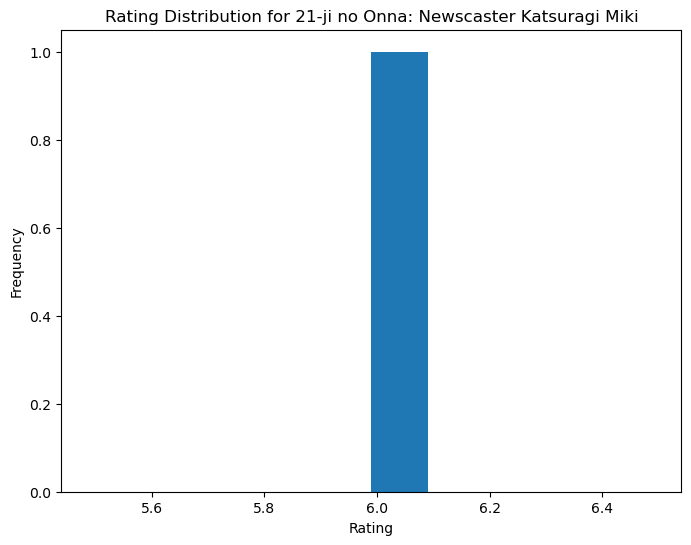

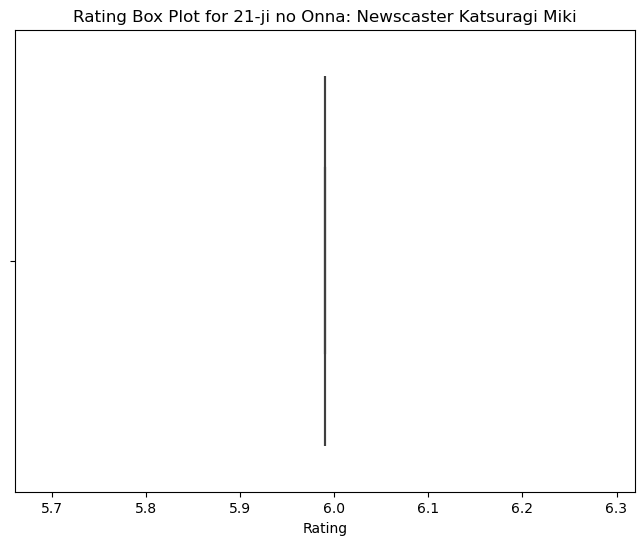

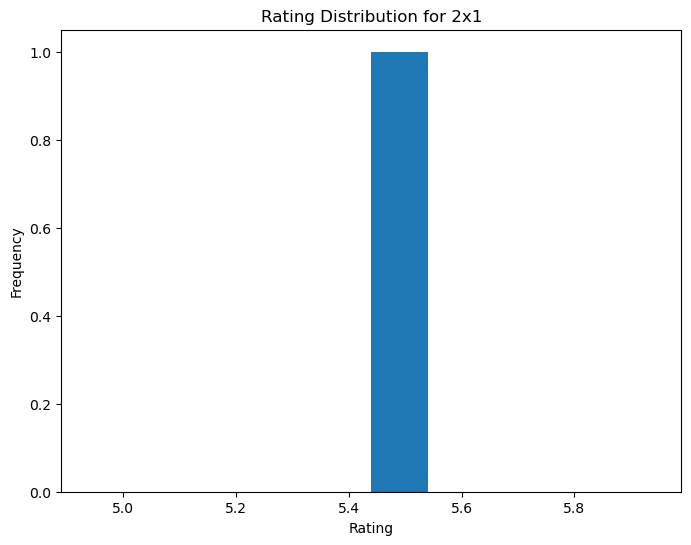

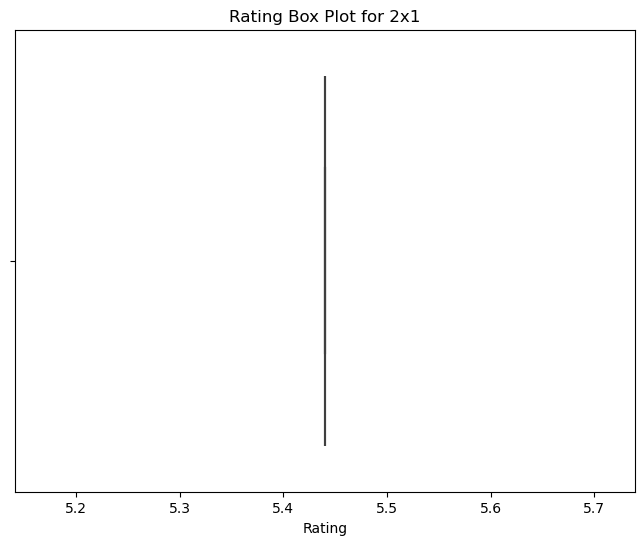

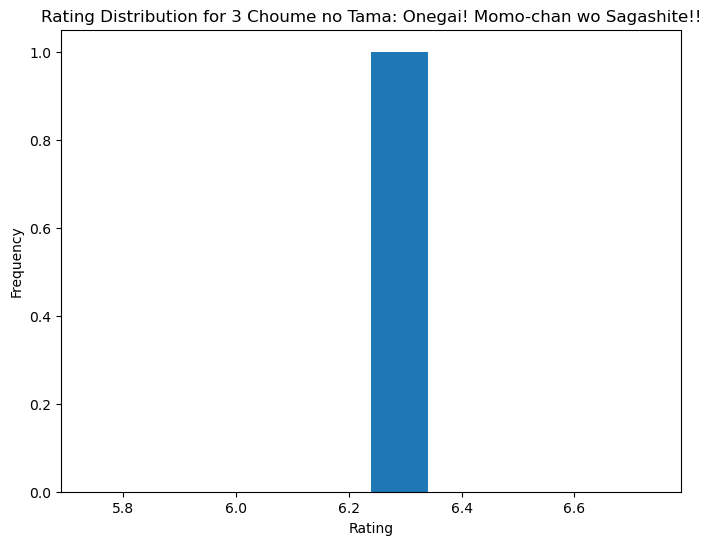

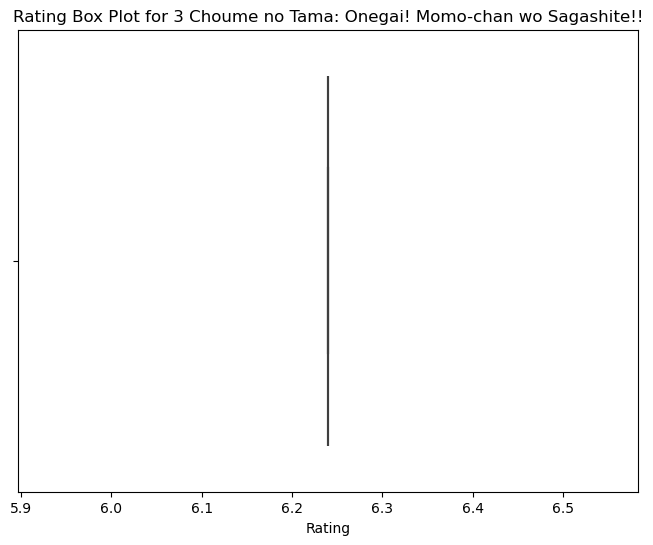

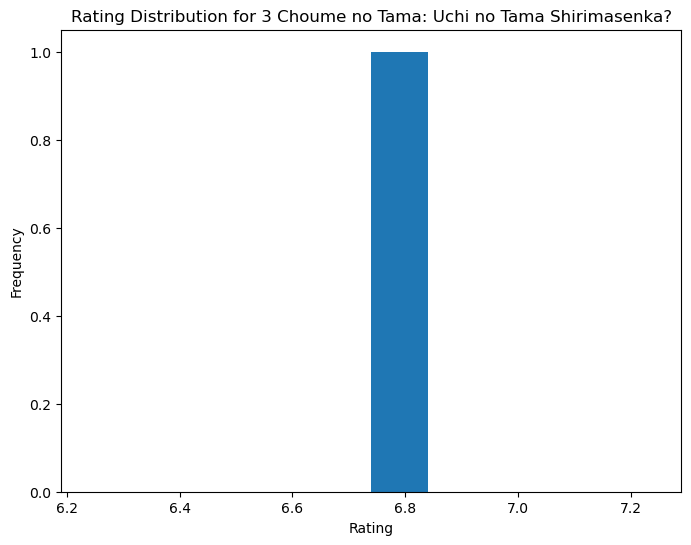

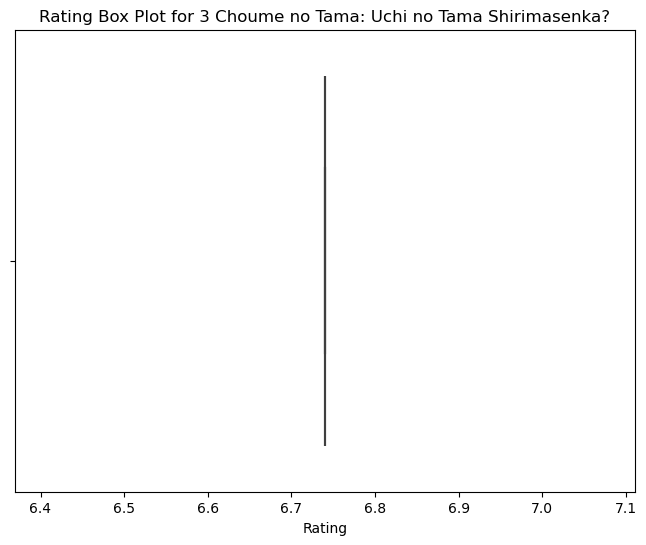

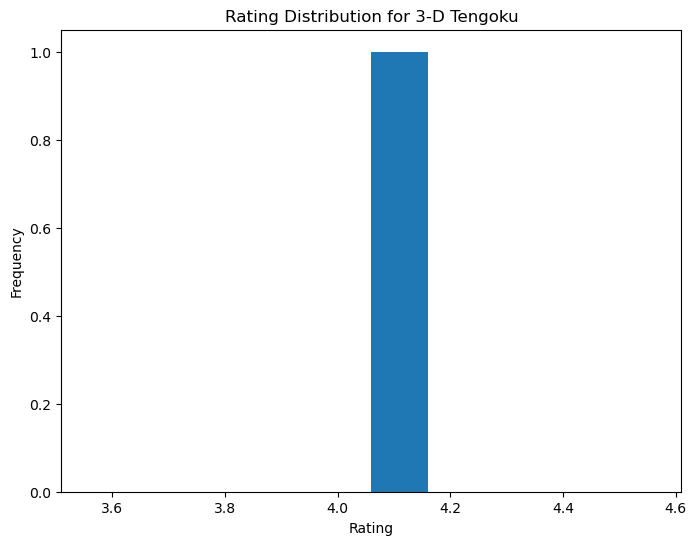

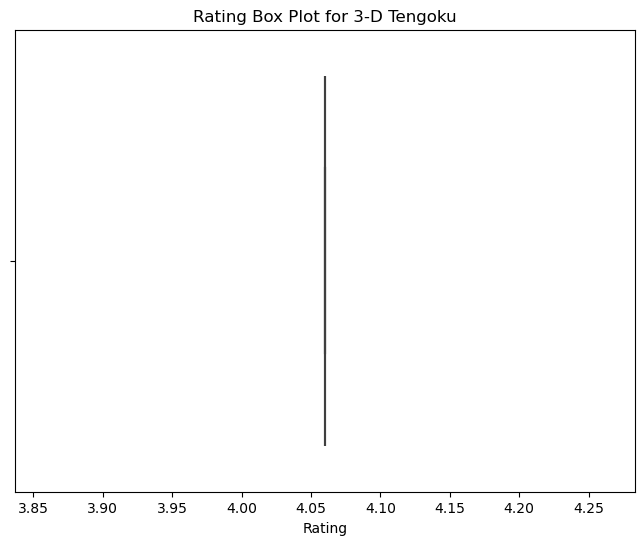

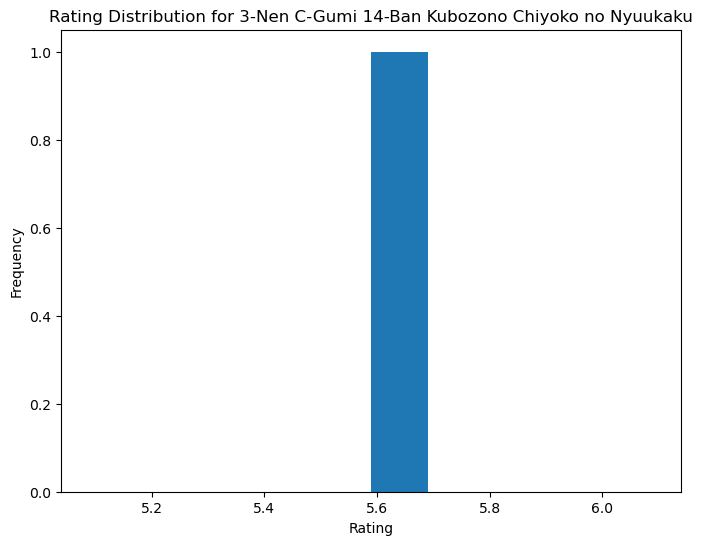

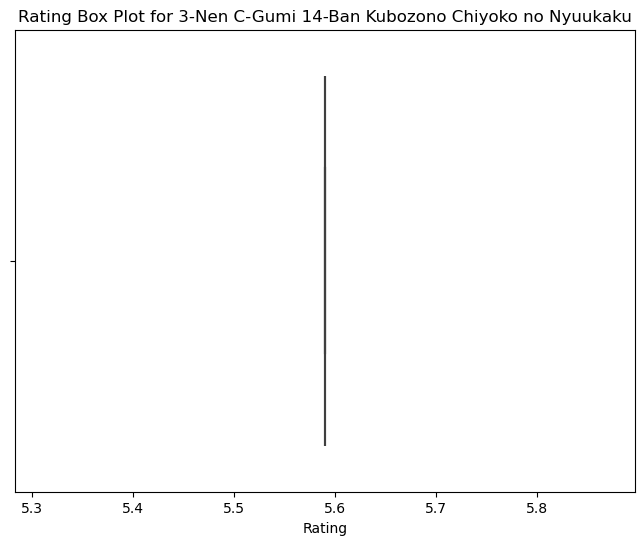

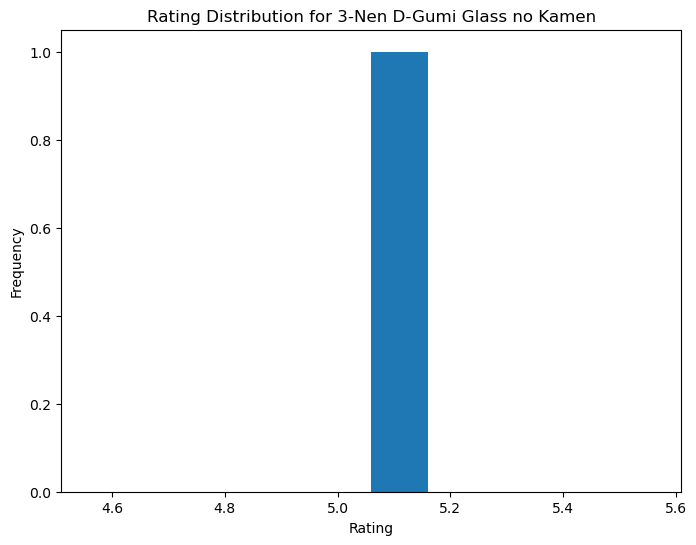

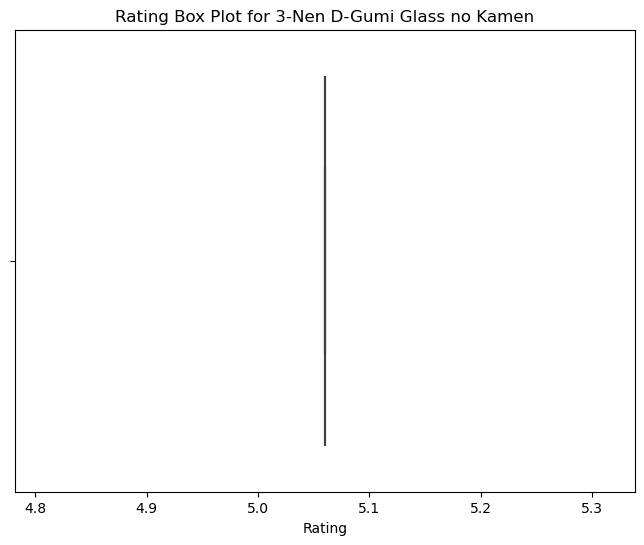

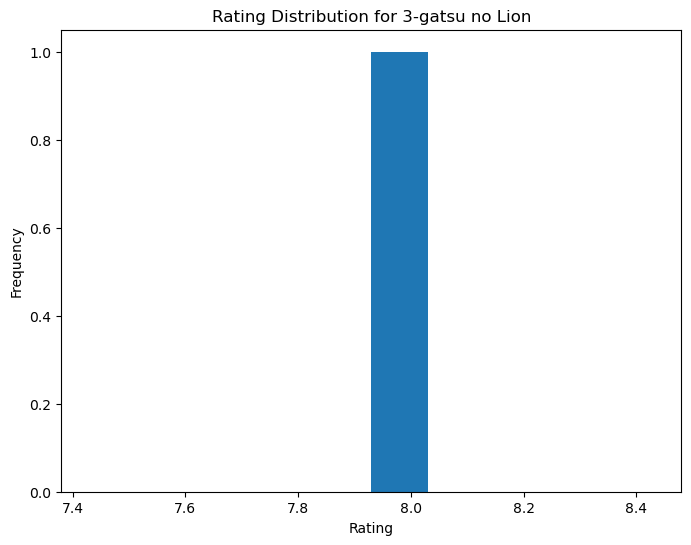

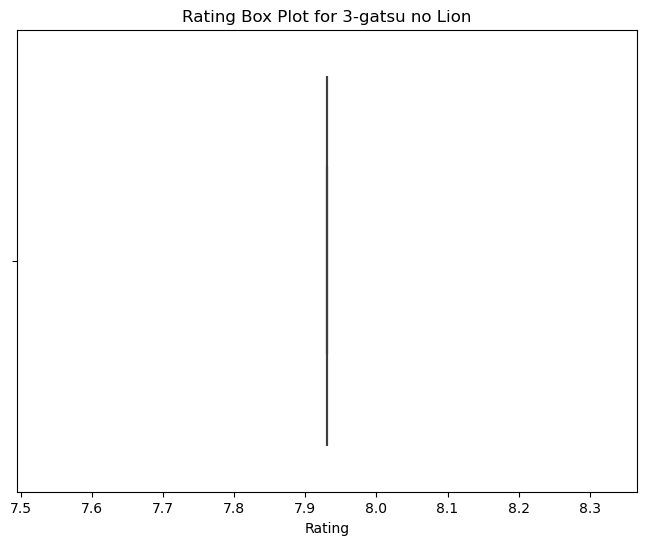

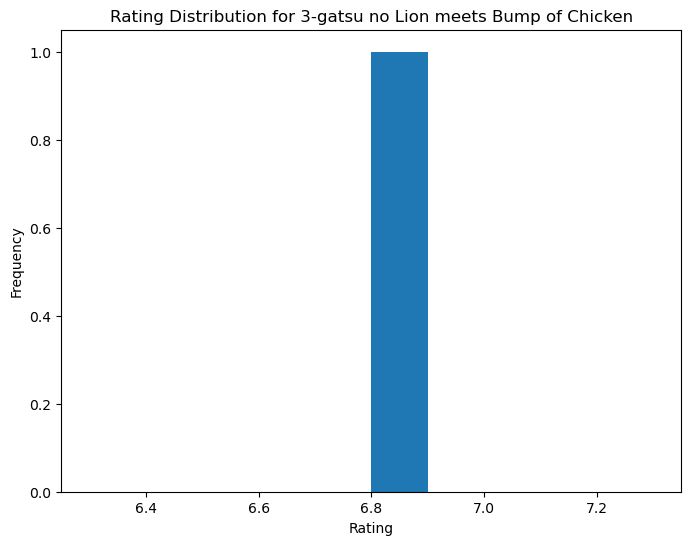

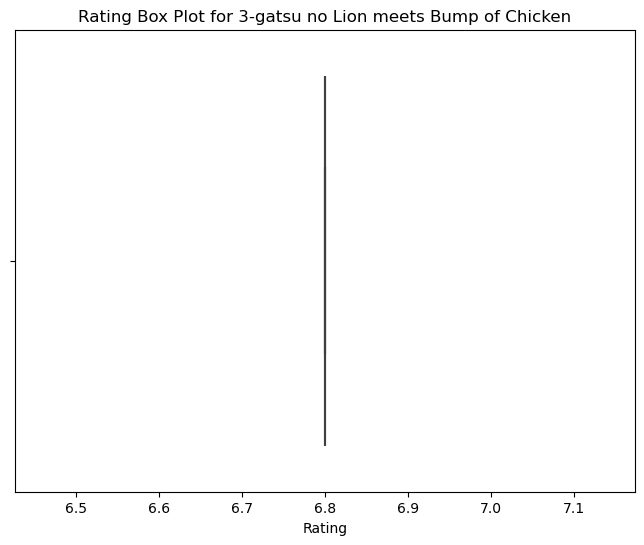

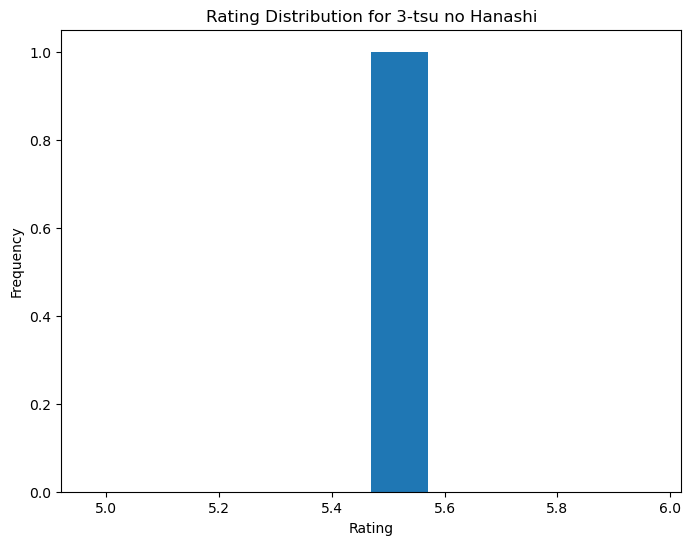

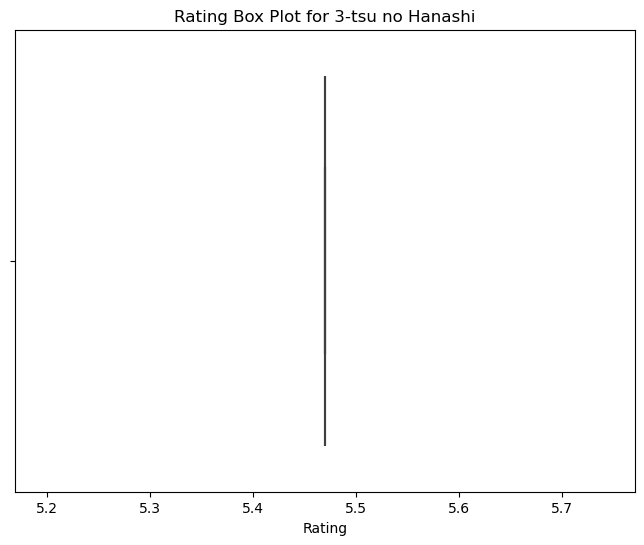

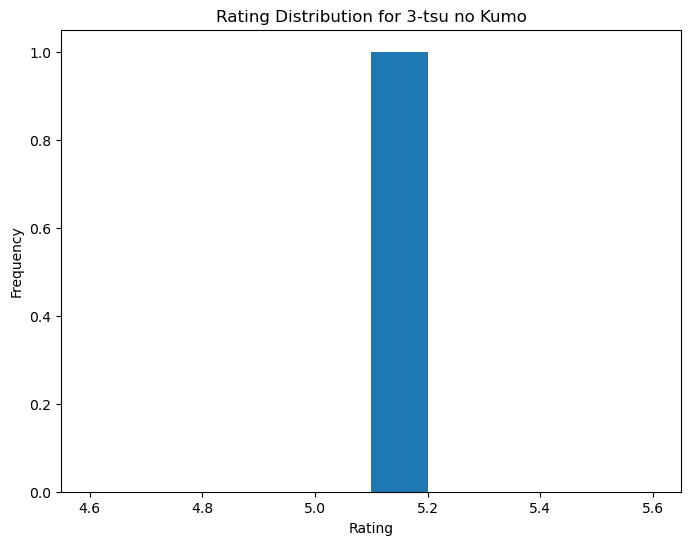

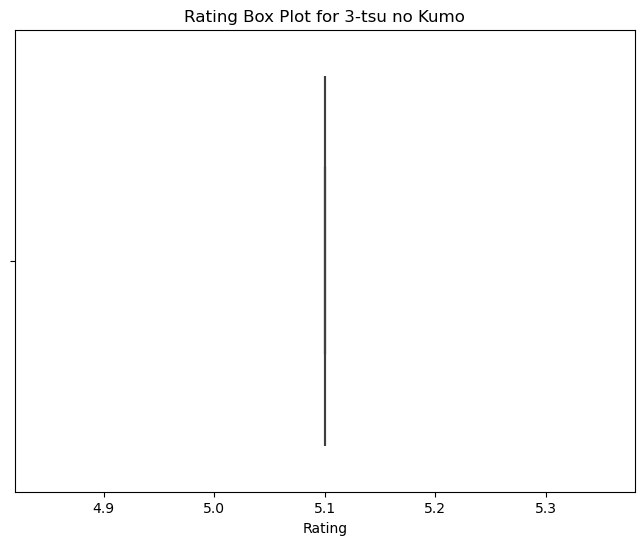

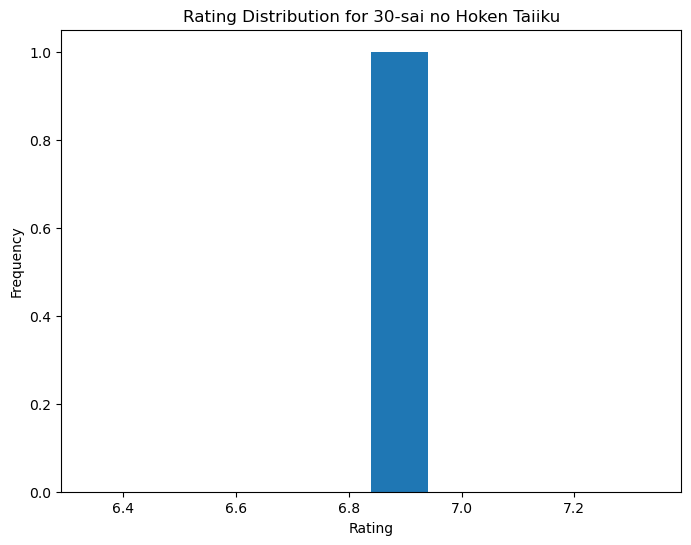

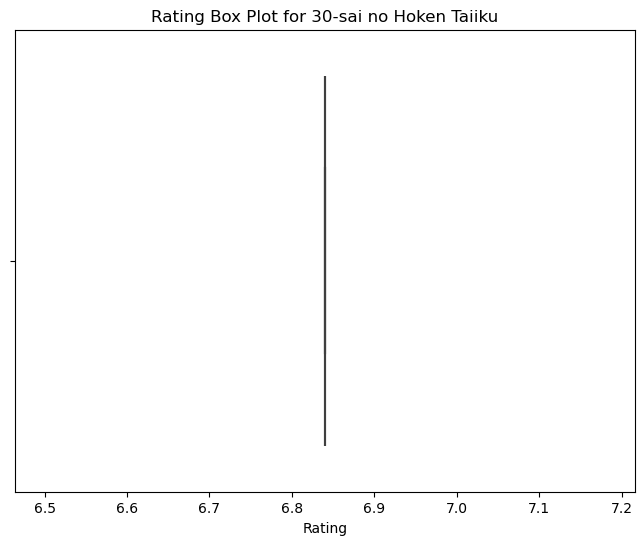

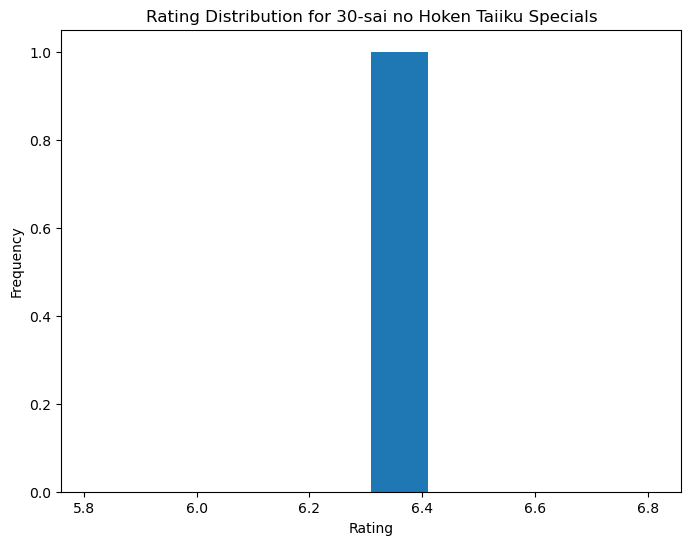

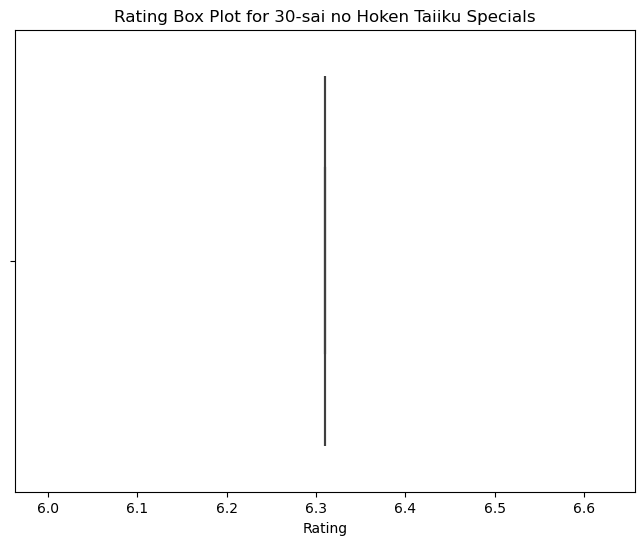

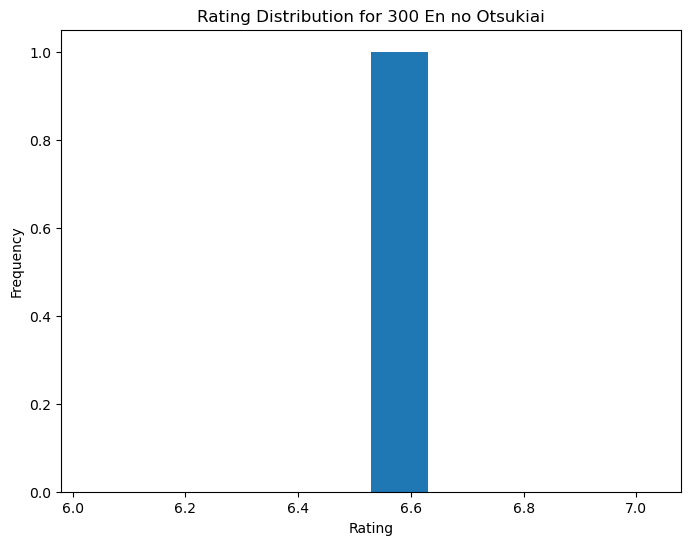

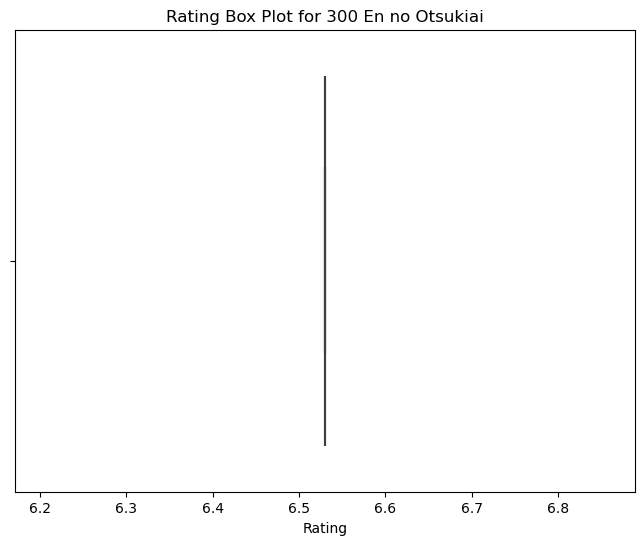

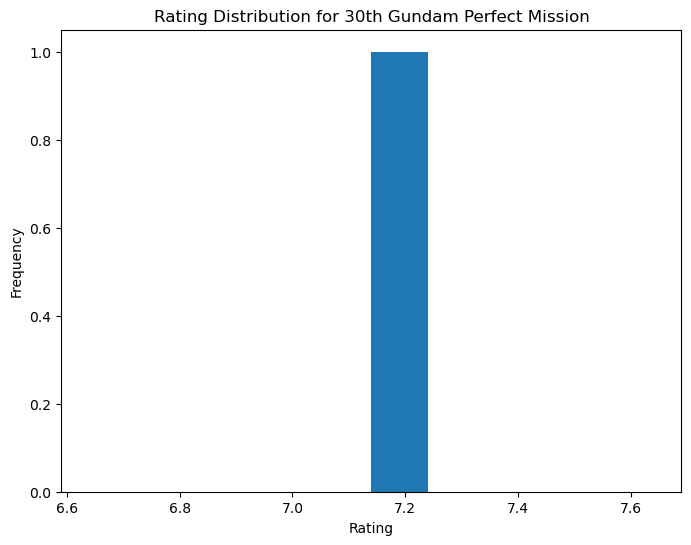

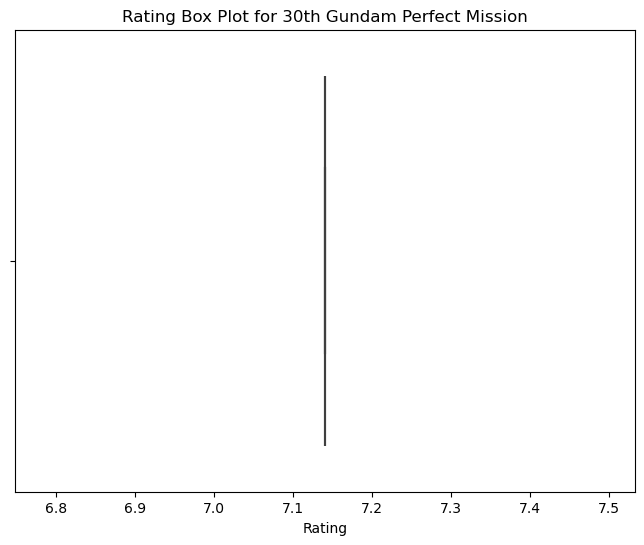

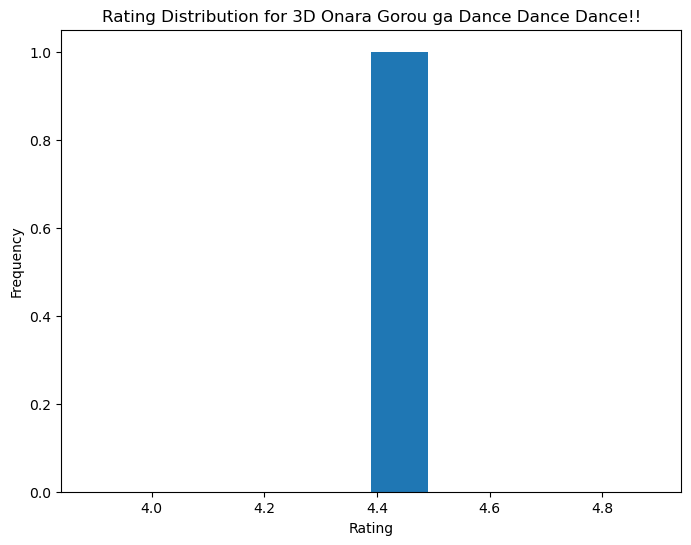

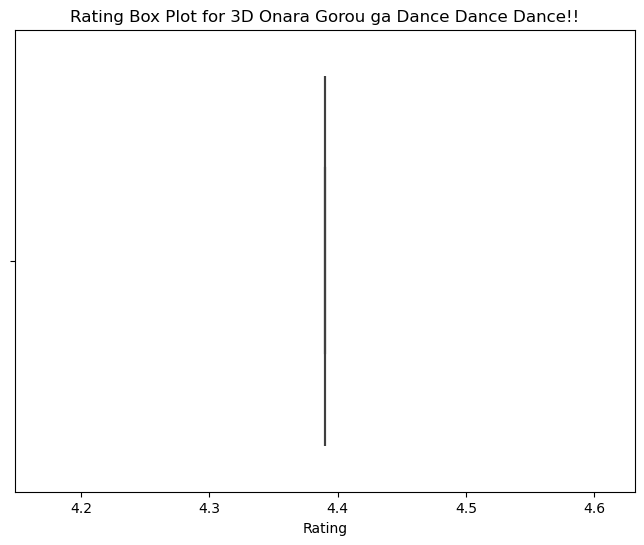

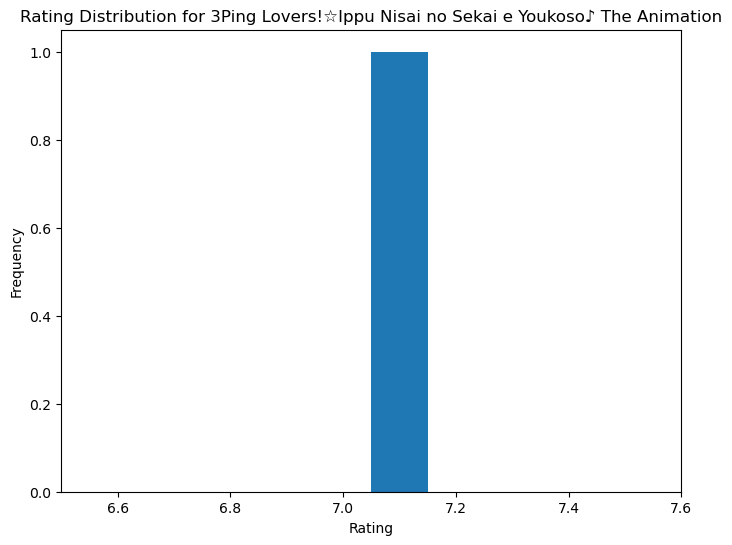

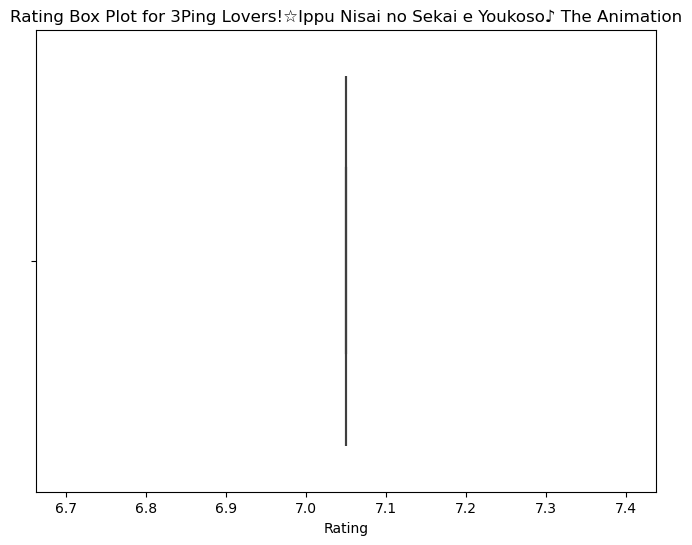

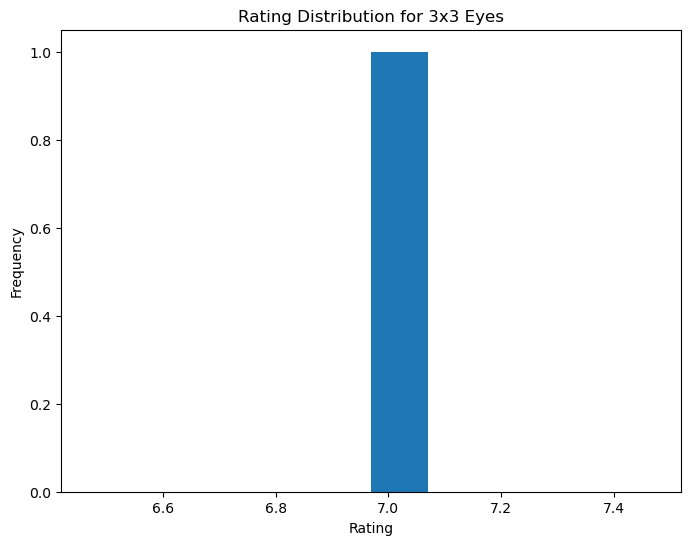

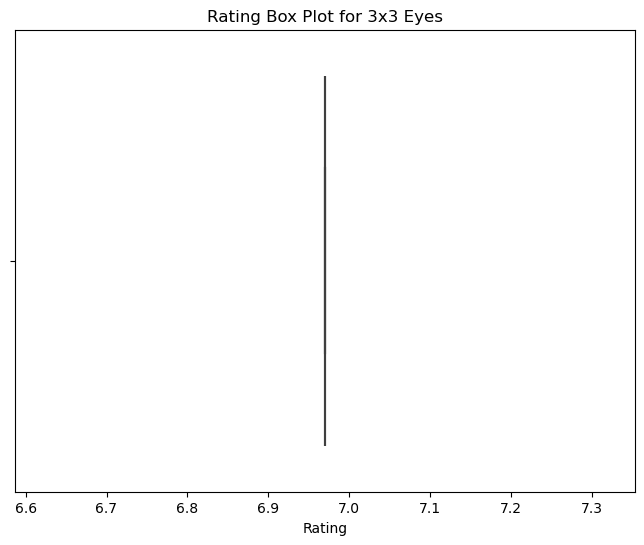

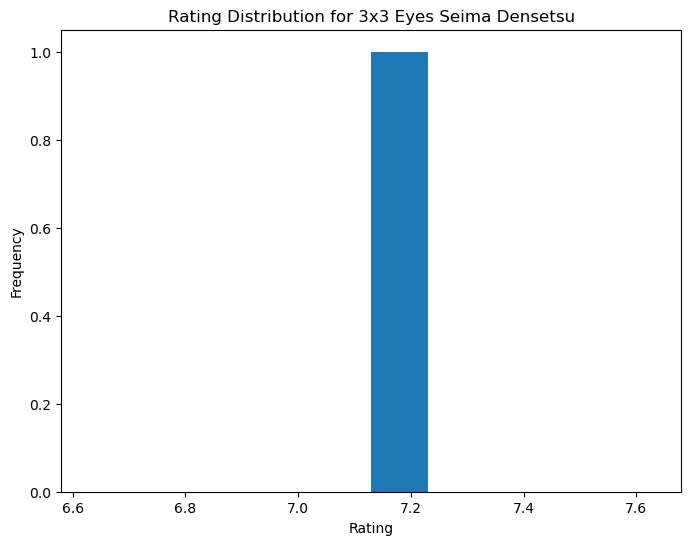

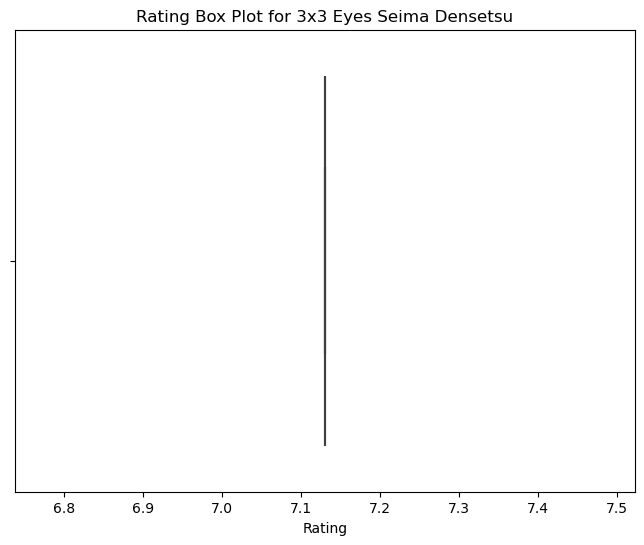

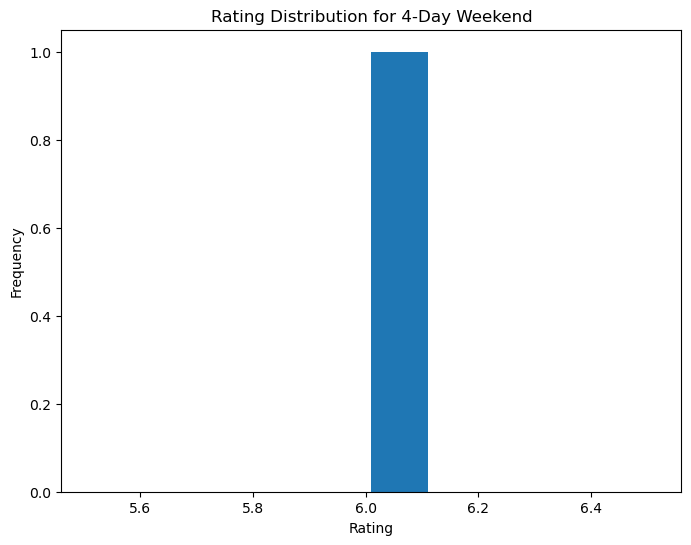

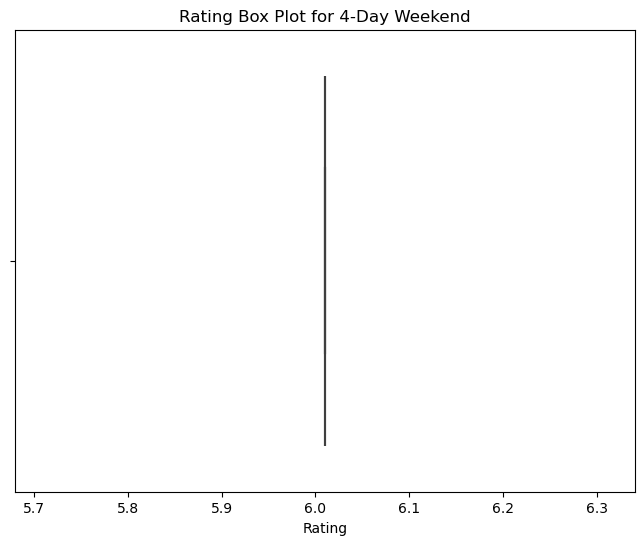

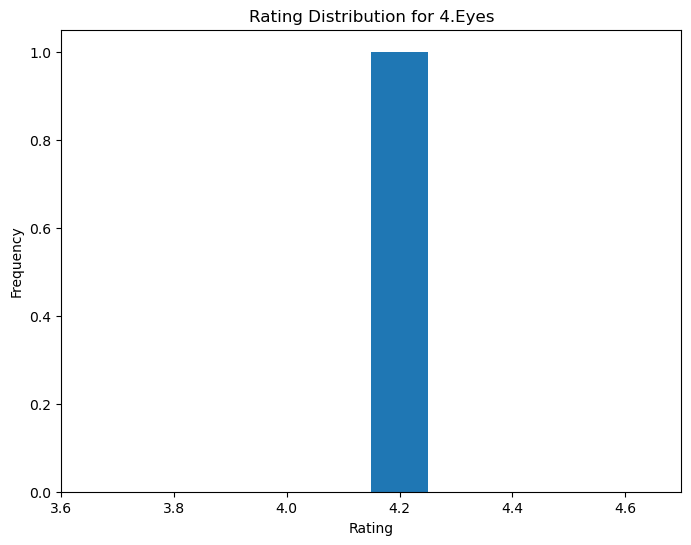

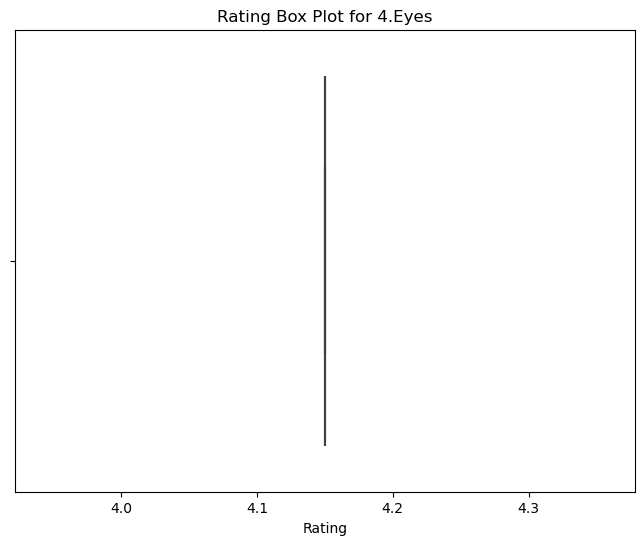

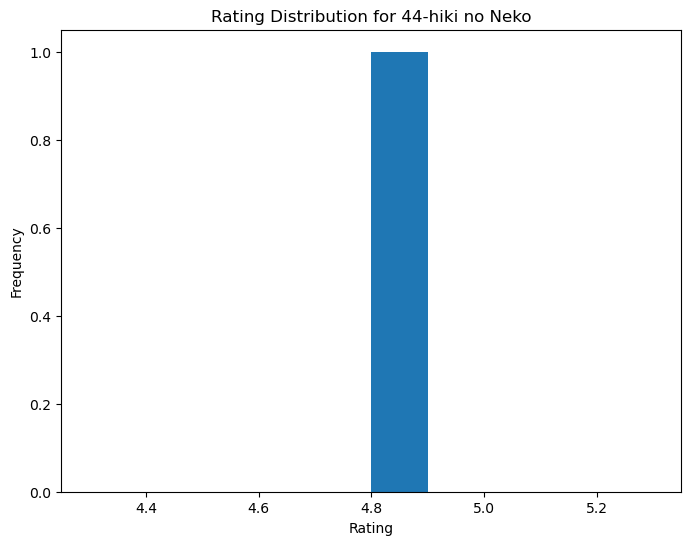

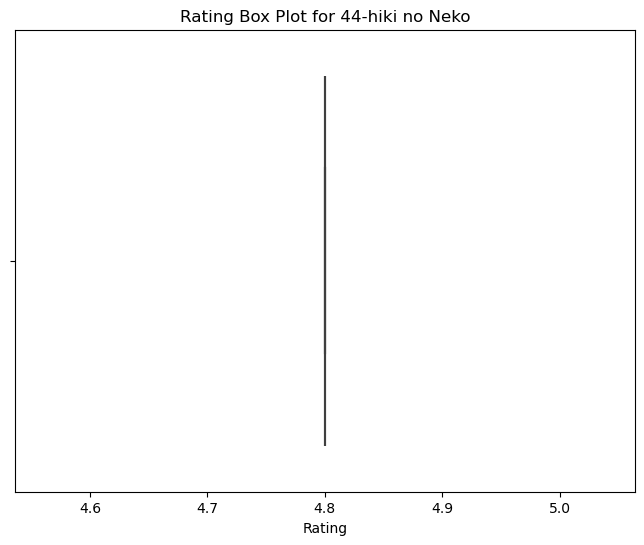

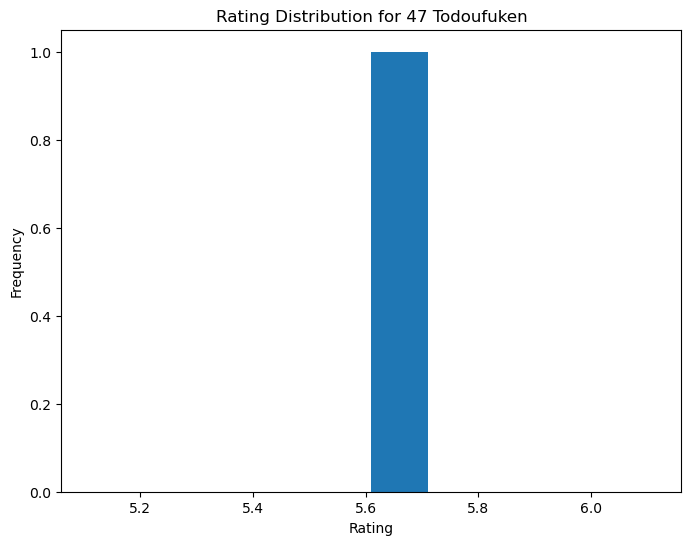

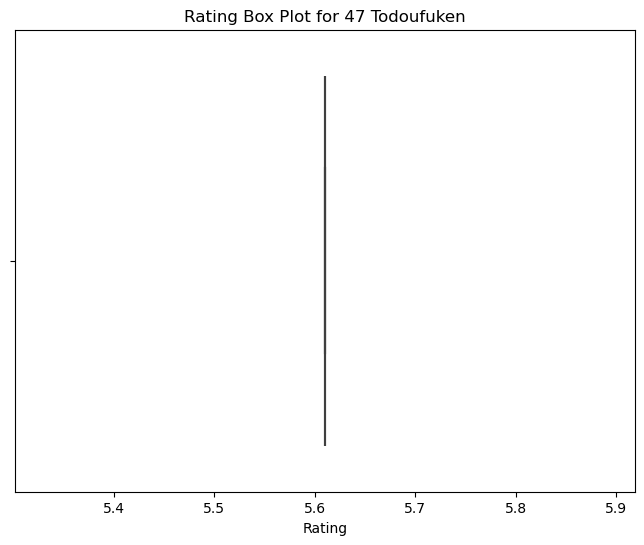

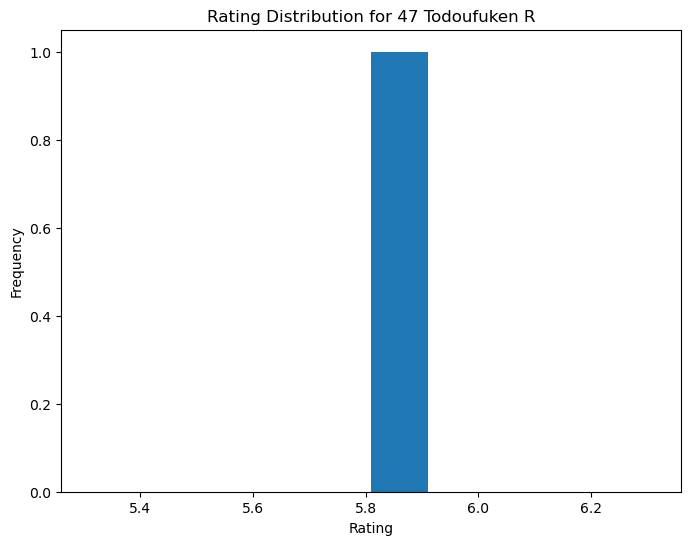

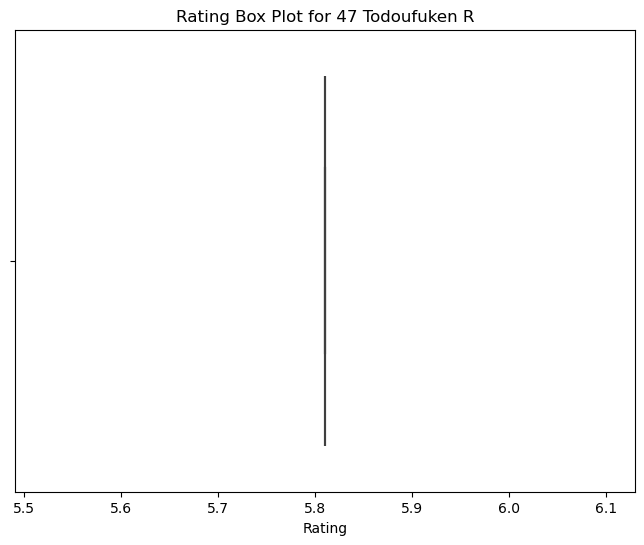

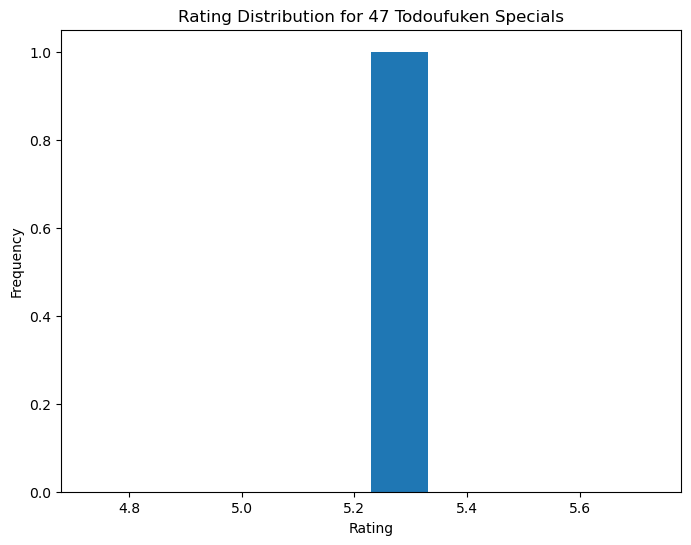

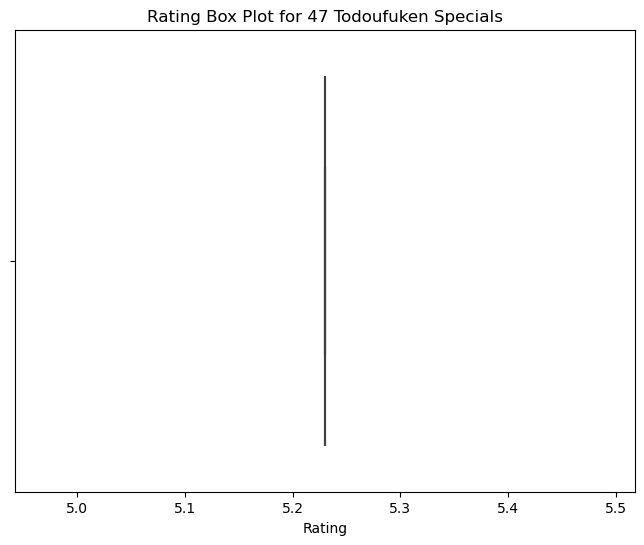

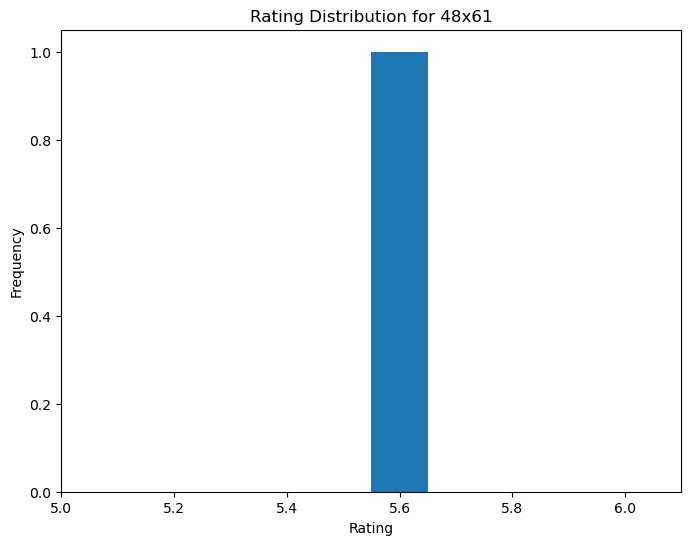

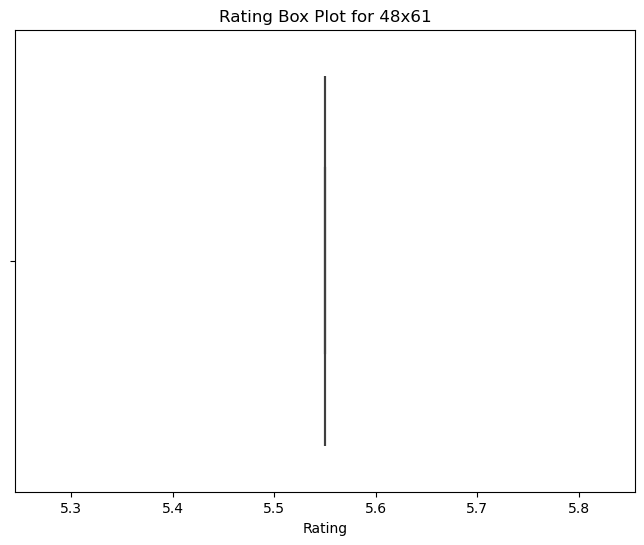

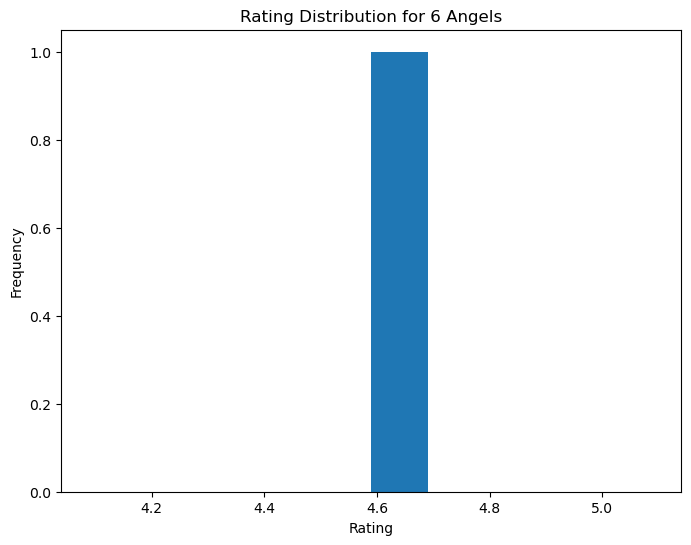

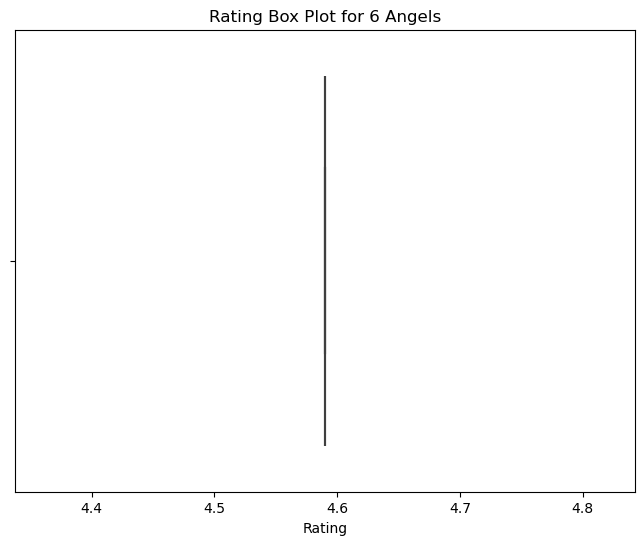

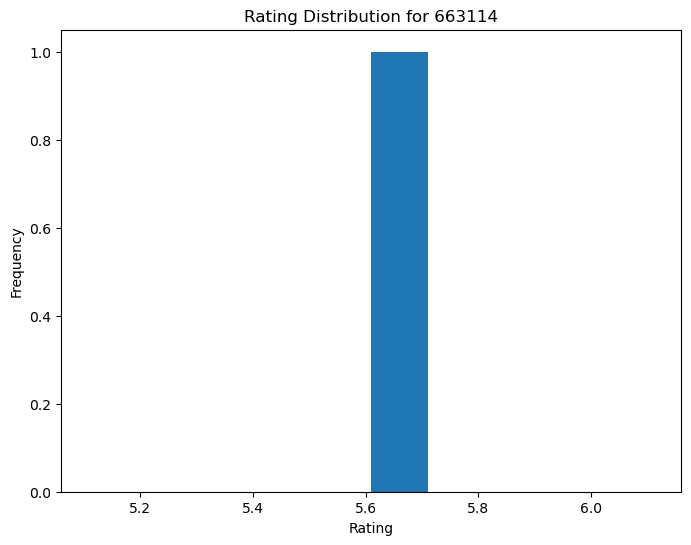

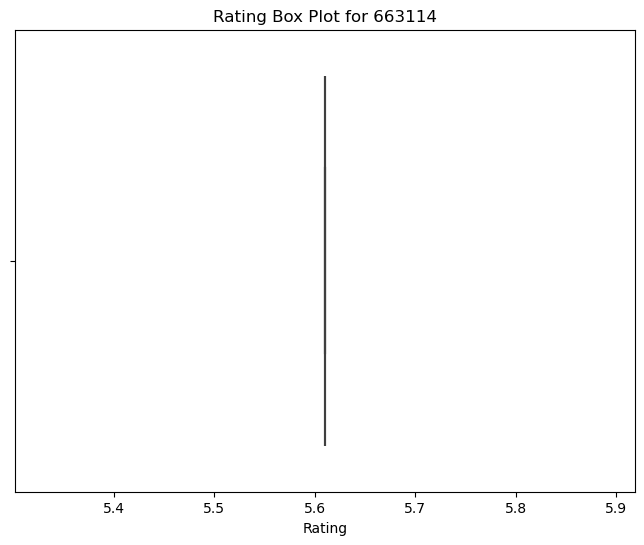

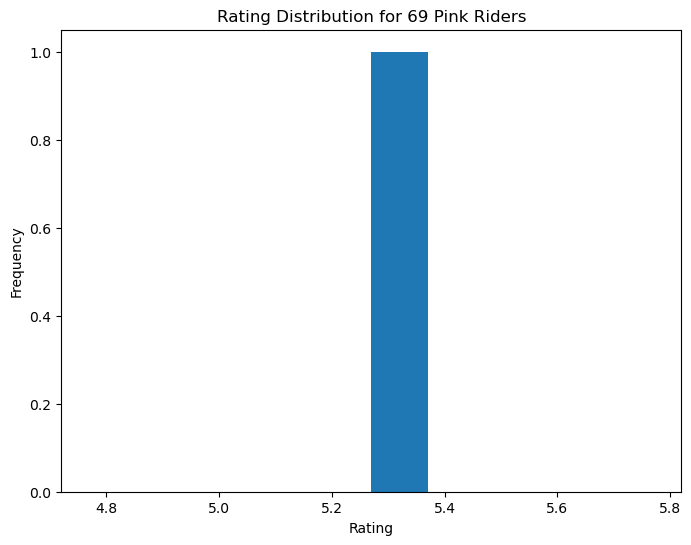

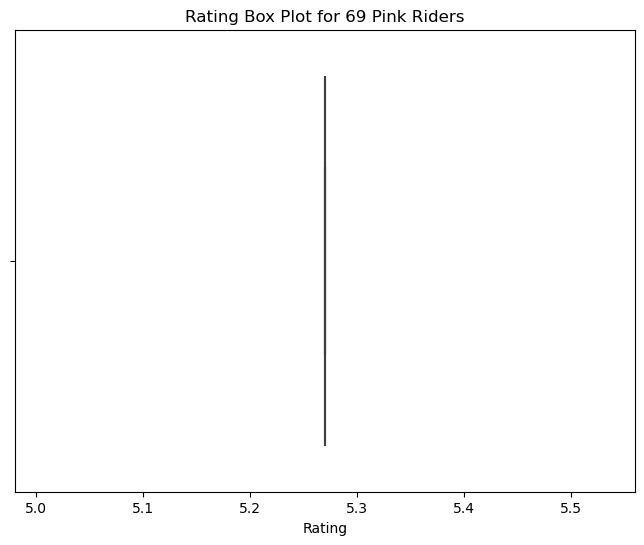

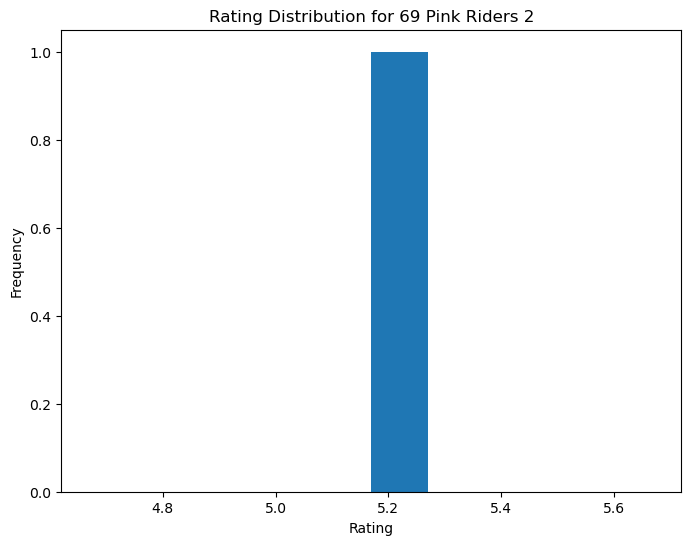

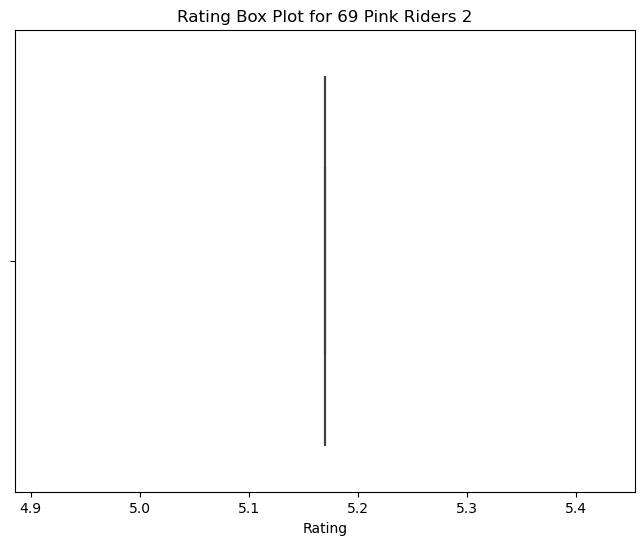

C:\Users\Lenovo\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6826: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Lenovo\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

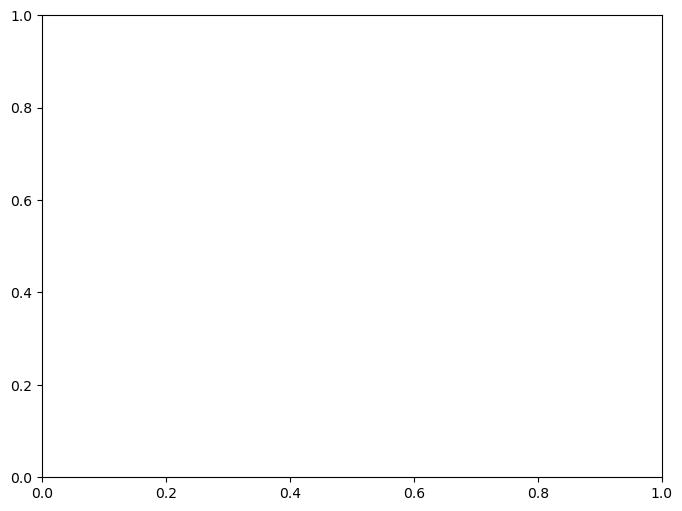

In [14]:
# prompt: create histograms or box plots for each anime name
# # to see the spread of ratings for that specific anime. 

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df' with columns 'name' and 'rating'

# Group by anime name and create histograms or box plots for each anime
for name, group in df.groupby('name'):
  plt.figure(figsize=(8, 6))  # Adjust figure size as needed
  
  # Histogram
  plt.hist(group['rating'], bins=10)
  plt.title(f"Rating Distribution for {name}")
  plt.xlabel("Rating")
  plt.ylabel("Frequency")
  plt.show()

  # Box plot
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=group['rating'])
  plt.title(f"Rating Box Plot for {name}")
  plt.xlabel("Rating")
  plt.show()

In [15]:
count_rating = df.groupby("name")["rating"].count().sort_values(ascending = False)
count_rating

name
Shi Wan Ge Leng Xiaohua                        2
Saru Kani Gassen                               2
Osomatsu-kun: Iyami wa Hitori Kaze no Naka     1
Oshiri Kajiri Mushi (TV) 3rd Season            1
Oshiri Kajiri Mushi (TV) 4th Season            1
                                              ..
Idol Kyousei Sousa                             0
Busou Shoujo Machiavellianism                  0
Haikara-san ga Tooru Movie                     0
Nyanko Days                                    0
Fate/stay night Movie: Heaven&#039;s Feel 3    0
Name: rating, Length: 12292, dtype: int64

In [20]:
df_recom = df.pivot_table(index='anime_id',columns='name',values='rating')
df_recom.iloc[:5,:5]

name,&quot;0&quot;,"&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu",&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie
anime_id,,,,,
1,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN


In [21]:
df.name.value_counts().head(10)

name
Shi Wan Ge Leng Xiaohua                           2
Saru Kani Gassen                                  2
Bakabon Osomatsu no Karee wo Tazunete Sansenri    1
Backkom Meogeujan Yeohaeng                        1
Backkom Mission Impossible                        1
Backkom Specials                                  1
Backstage Idol Story                              1
Bad Badtz-Maru no Ari to Kirigirisu               1
Bad Badtz-Maru no Ookami ga Kita!                 1
Bad Badtz-Maru no Ore no Pochi wa Sekaiichi       1
Name: count, dtype: int64

In [24]:
def find_corr(df, name):
    similar_to_movie = df.corrwith(df[name])
    similar_to_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    similar_to_movie = similar_to_movie.sort_values(by = 'Correlation', ascending = False)
    print(similar_to_movie)
    return similar_to_movie

anime1 = ['Shi Wan Ge Leng Xiaohua','Shi Wan Ge Leng Xiaohua','Saru Kani Gassen','Bakabon Osomatsu no Karee wo Tazunete Sansenri','Backkom Meogeujan Yeohaeng','Backkom Mission Impossible','Backkom Specials','Backstage Idol Story','Bad Badtz-Maru no Ari to Kirigirisu','Bad Badtz-Maru no Ookami ga Kita!','Bad Badtz-Maru no Ore no Pochi wa Sekaiichi']

# Let's try with "Shi Wan Ge Leng Xiaohua"
for anime in anime1:
# Recommendations
    find_corr(df_recom, anime)

                                                    Correlation
name                                                           
Shi Wan Ge Leng Xiaohua                                     1.0
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]
                                                    Correlation
name                                                           
Shi Wan Ge Len

C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Lenovo\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


                                                    Correlation
name                                                           
&quot;0&quot;                                               NaN
&quot;Aesop&quot; no Ohanashi yori: Ushi to Kae...          NaN
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hats...          NaN
&quot;Bungaku Shoujo&quot; Memoire                          NaN
&quot;Bungaku Shoujo&quot; Movie                            NaN
...                                                         ...
xxxHOLiC Movie: Manatsu no Yoru no Yume                     NaN
xxxHOLiC Rou                                                NaN
xxxHOLiC Shunmuki                                           NaN
Üks Uks                                                     NaN
◯                                                           NaN

[12062 rows x 1 columns]


# Interview Questions

* **Focus:**  Finds users similar to a target user based on their past ratings or preferences.
* **Mechanism:** If user A and user B have similar tastes (rated many of the same items similarly), then we can predict user A's rating for an item that user B has rated highly. 
* **Process:**
    1. Identify users with similar preferences to the target user (e.g., using cosine similarity).
    2. Find items that these similar users have rated highly but the target user hasn't interacted with yet.
    3. Recommend these items to the target user.
* **Advantages:**
    * Can personalize recommendations based on individual user preferences.
    * Can capture unique tastes and preferences.
* **Disadvantages:**
    * Can be computationally expensive, especially with a large user base.
    * Prone to the "cold start" problem for new users who haven't rated enough items to find similar users.
    * User tastes can change over time, leading to less accurate predictions.


**Item-Based Collaborative Filtering:**

* **Focus:**  Finds items similar to items a user has liked in the past.
* **Mechanism:** If user A rated item X and item Y highly, it suggests that item X and item Y are similar in terms of user preferences. We can then recommend item Y to other users who liked item X.
* **Process:**
    1. Calculate the similarity between items based on how users rated them (e.g., using cosine similarity).
    2. Identify items similar to the ones a target user has liked.
    3. Recommend these similar items to the target user.
* **Advantages:**
    * More stable and less prone to changes in user preferences.
    * Computationally more efficient compared to user-based filtering.
    * Less susceptible to the "cold start" problem for new users.
* **Disadvantages:**
    * Can be less personalized than user-based filtering.
    * May not discover items outside the user's existing interests.


**In simpler terms:**

* **User-based:** "People like you also liked..."
* **Item-based:** "If you liked this, you might also like..."